# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 04. Conformer для задачи денойзинга`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__8 апреля 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__11 мая 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __16 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import math
import warnings
from typing import Dict, List, Optional, Tuple, Union

import glob
import regex
import numexpr

import tqdm.notebook as tqdm

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import librosa
import torchaudio

from omegaconf import OmegaConf

import matplotlib_inline
import matplotlib.pyplot as plt

from IPython.display import display, Audio, Markdown

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

# `Формат сдачи задания`

При сдаче задания необходимо дополнительно прикрепить:
1. Tensorboard логи для всех успешно проведённых экспериментов
2. Чекпоинт лучшей модели
3. $10$ аудио примеров работы модели на тестовых выборках в формате (исходное аудио, добавленный шум, зашумлённое аудио и результат денойзинга)

Для получения полного балла необходимо преодолеть порог по качеству: $\text{SNR}_{\text{model}} \ge 11dB$ на всех $4$ выборках. 

## `Задача денойзинга. Введение`

**Задача денойзинга** заключается в удалении посторонних звуков из входного аудио без ухудшения целевого сигнала. Стоит отметить, что выбор целевого и постороннего сигнала может разниться от задачи к задаче, например, можно рассматривать как удаление фонового шума для восстановления человеческой речи, так и наоборот, удаление речи из концертной записи. 

В данном задании Вам предлагается научиться отделять человеческую речь от различного шума.

Хотя существуют [методы](https://arxiv.org/pdf/2111.08678.pdf) для unsupervised решения этой задачи, более простым и интуитивным подходом является **supervised обучение**. Используя выборку "чистых" аудио $\mathcal{A} = \{a_{i}\}_{1}^{m}$ и набор шумов $\mathcal{N} = \{n_{j}\}_{1}^{k}$, можно создать синтетический датасет из пар *`чистое аудио`*/*`зашумлённое аудио`*.

В качестве функции потерь логично использовать метрику схожести между исходным аудио и аудио, восстановленным из зашумлённого сигнала. Такой метрикой может служить как расстояние между спектрограммами, так и расстояние между Waveforms.

В данной работе предлагается использовать $L_{1}$ расстояние между Waveforms:
$$
\mathfrak{L} = \mathbb{E}\mathcal{L}(a_{i}, \text{Denoiser}_{\theta}(a_{i} + \gamma n_{j})) = |a_{i} - \text{Denoiser}_{\theta}(a_{i} + \gamma n_{j})|_{1} \rightarrow \min_{\theta},\\ i \sim U\{1, ..., m\}, j \sim U\{1, ..., k\}, \gamma \sim U[\gamma_{min}, \gamma_{max}],
$$
где $\gamma$ задаёт мощность шума относительно сигнала.

В качестве модели для восстановления сигнала $\text{Denoiser}_{\theta}$ предлагается использовать архитектуру [Conformer](https://arxiv.org/pdf/2005.08100.pdf). 

Более подробно о том, как задавать лосс на спектрограммах можно посмотреть в статье [SE-Conformer: Time-Domain Speech Enhancement Using Conformer](https://www.isca-speech.org/archive/pdfs/interspeech_2021/kim21h_interspeech.pdf).

## `Рекомендуемые гиперпараметры`

При создании конфигов часто появляется желание определять одни переменные через другие. Обычно, такой встроенной функциональности нет, однако, её часто можно добавить. Например, в библиотеке `omegaconf` можно определять собственные ресолверы. 

Естественное желание реализовать ресолвер для интерполяции переменных с помощью функции `eval`:
```python
OmegaConf.register_new_resolver('eval', eval, replace=True)
```

**Однако, никогда так не делайте!**

Использование `eval` для парсинга произвольных конфигов несёт [серьёзную угрозу безопасности](https://github.com/omry/omegaconf/issues/91), хотя и является [предлагаемым способом в документации](https://omegaconf.readthedocs.io/en/2.3_branch/how_to_guides.html#how-to-perform-arithmetic-using-eval-as-a-resolver). 

К счастью, [существуют безопасные альтернативы](https://stackoverflow.com/questions/2371436/evaluating-a-mathematical-expression-in-a-string), например, `numexpr.evaluate`, который может вычислять только небольшое подмножество языка Python, а именно арифметические операции. Обычно, этого хватает в большинстве случаев.

In [ ]:
OmegaConf.register_new_resolver('eval', lambda expr: numexpr.evaluate(expr).item(), replace=True)

config = OmegaConf.create({
    # Частота дискретизации аудио 
    'sample_rate': 16000,
    # Диапазон SNR в децибелах для зашумления
    'snr_range': (2, 5),

    # Параметры DataLoader
    'batch_size': 8,
    'num_workers': 8,

    # Параметры итоговой модели
    'n_fft': 1024,
    'hop_length': '${eval:${n_fft} // 4}',
    'win_length': '${n_fft}',
    'window': 'hann_window',
    'n_layers': 6,
    'd_model': '${eval:${n_fft} // 2}',
    'd_ff': '${eval:4 * ${d_model} // 2}',
    'n_heads': 4,
    'kernel_size': 31,
    'xscale': True,
    'dropout': 0.1,
    'dropout_emb': '${dropout}',
    'dropout_att': '${dropout}',
    
    # Параметры оптимизации
    'base_lr': 0.2,
    'min_lr': 1e-5,
    'max_norm': 0.01,
    
    # Какие позиционные эмбеддинги использовать
    'use_RoPE': False
})
print(OmegaConf.to_yaml(config, resolve=True))

# `Часть 0. Загрузка и предобработка данных (1 балл)`

Скачаем [чистые данные](https://openslr.elda.org/12/) и [аудио с шумом](https://openslr.elda.org/17/). Для обучения будем использовать аудиокниги на английском языке. Также, загрузим [русскоязычные аудио](https://openslr.elda.org/96/) для тестирования на out-of-domain данных. **Данные весят больше 15GB**

In [ ]:
# ! wget https://www.openslr.org/resources/17/musan.tar.gz

In [ ]:
# ! wget https://www.openslr.org/resources/12/train-clean-100.tar.gz

In [ ]:
# ! wget https://www.openslr.org/resources/96/ruls_data.tar.gz

In [ ]:
# ! tar xf musan.tar.gz

In [ ]:
# ! tar xf train-clean-100.tar.gz

In [ ]:
# ! mkdir ruls_data
# ! tar -xf ruls_data.tar.gz -C ruls_data

In [ ]:
noise_files_template = '/kaggle/input/msu-prac-denoising-thick-dataset/musan/musan/noise/*/*.wav'
audio_files_template = '/kaggle/input/msu-prac-denoising-thick-dataset/train-clean-100/LibriSpeech/train-clean-100/*/*/*.flac'
ru_audio_files_template = '/kaggle/input/msu-prac-denoising-thick-dataset/ruls_data/dev/audio/*/*/*.wav'

Посмотрим на несколько сэмплов:

In [ ]:
def display_audio(
    audiofile_path: Union[str, torch.Tensor], title: str = 'Пример аудио сигнала', sample_rate: Optional[int] = 16000
) -> None:
    '''
    :param Union[str, torch.Tensor] audiofile_path: Path to the audiofile or one-dimensional signal 
    :param str title: Plot title
    :param Optional[int] sample_rate: Signal sample rate
    '''
    if isinstance(audiofile_path, str):
        signal, sample_rate = torchaudio.load(audiofile_path)
        signal = torch.mean(signal, dim=0)
    else:
        signal, sample_rate = audiofile_path, sample_rate
    signal = signal.cpu().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    ax.plot(np.arange(signal.shape[0]) / sample_rate, signal)

    ax.grid(True)

    ax.set_xlabel('Время')
    ax.set_ylabel('Магнитуда')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
    
    display(Audio(data=signal, rate=sample_rate, embed=True))
    
def mprint(*strings: List[str]) -> None:
    '''
    Display list of strings as a Markdown
    :param List[str] strings: List of texts
    '''
    for string in strings:
        display(Markdown(string))

In [ ]:
display_audio(sorted(glob.glob(noise_files_template))[0], 'Пример шума')
display_audio(sorted(glob.glob(audio_files_template))[0], 'Пример "чистого" аудио')

Для работы с данными реализуем класс-датасет для аудио.

**Tips:** `glob.glob`, `torchaudio.functional.resample`

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, template: str, sample_rate: int):
        '''
        :param str template: Audio files template
        :param int sample_rate: Desired sample rate
        '''
        super().__init__()
        
        self.sample_rate = sample_rate
        self.paths = glob.glob(template)
        
        self.paths = sorted(self.paths)
        
    def __len__(self) -> int:
        '''
        Number of audio files
        :rtype: int
        '''
        # YOUR CODE HERE
        return len(self.paths)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        '''
        :param int idx: Audio file Id
        :return: One-dimensional signal with desired sample rate
        :rtype: torch.Tensor
        '''
        # YOUR CODE HERE
        waveform, orig_rate = torchaudio.load(self.paths[idx])
        if orig_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, orig_rate, self.sample_rate)
        waveform = torch.mean(waveform, dim=0)
        return waveform

In [ ]:
audio_ds = AudioDataset(audio_files_template, config.sample_rate)
noise_ds = AudioDataset(noise_files_template, config.sample_rate)
ru_clean_ds = AudioDataset(ru_audio_files_template, config.sample_rate)

In [ ]:
mprint(
    f'Число "чистых" аудио: ${len(audio_ds)}$', 
    f'Число шумов: ${len(noise_ds)}$', 
    f'Число русскоязычных аудио: ${len(ru_clean_ds)}$'
)

Для создания синтетического датасета реализуем набор вспомогательных функций:
1. `calc_energy(signal)` — подсчёт энергии сигнала в децибелах $E_{dB} = 10 \log_{10}E = 10 \log_{10}\Bigg(\sum\limits_{n} f^{2}(n)\Bigg)$
2. `calc_snr(signal, noise)` — отношение сигнал-шум в децибелах $\text{SNR}_{dB} = 10\log_{10} \frac{E_{\text{signal}}}{E_{\text{noise}}}$
3. `calc_coefficient(signal, noise, snr)` — находит коэффициент $\gamma$, такой что $\text{SNR}_{dB}$ для `signal`, и $\gamma \times $`noise` равен `snr`

**Tips:** при реализации функций `calc_snr` удобно использовать функцию `calc_energy`, аналогично с функцией `calc_coefficient` и `calc_snr`. Не нужно реализовывать то, что вы уже написали в отдельной функции.

In [ ]:
def calc_energy(signal: torch.Tensor) -> torch.Tensor:
    '''
    :param torch.Tensor signal: (..., time) tensor of signals. Assume that padding value is always zero
    :return: (...) signal energy in decibels
    :rtype: torch.Tensor
    '''
    # YOUR CODE HERE
    E = torch.sum(signal ** 2, dim=-1)
    return 10 * torch.log10(E)

In [ ]:
def calc_snr(signal: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    '''
    :param torch.Tensor signal: (..., time) batch of audio signals. Assume that padding value is always zero
    :param torch.Tensor noise: (..., time) batch of noise signals. Assume that padding value is always zero
    :return: SNR in decibels
    :rtype: torch.Tensor
    '''
    # YOUR CODE HERE
    return calc_energy(signal) - calc_energy(noise)

In [ ]:
def calc_coefficient(signal: torch.Tensor, noise: torch.Tensor, snr: Union[torch.Tensor, float]) -> torch.Tensor:
    '''
    :param torch.Tensor signal: (..., time) batch of audio signals. Assume that padding value is always zero
    :param torch.Tensor noise: (..., time) batch of noise signals. Assume that padding value is always zero
    :param Union[torch.Tensor, float] snr: (...) target SNRs in decibels after 
        adding noise with desired coefficient
    :return: (...) coefficients for adding noise
    :rtype: torch.Tensor
    '''
    # YOUR CODE HERE
    signal_db = calc_energy(signal)
    noise_energy = torch.sum(noise ** 2, dim=-1)
    E_required = 10 ** ((signal_db - snr) / 10)
    gamma = torch.sqrt(E_required / noise_energy)

    return gamma

In [ ]:
signal = torch.tensor(np.random.default_rng(0).normal(size=(3, 100007)), dtype=torch.float32)
noise = torch.tensor(np.random.default_rng(1).normal(size=(3, 100007)), dtype=torch.float32)

# Check calc_energy
signal_E, noise_E = calc_energy(signal), calc_energy(noise[0])

assert tuple(signal_E.shape) == (3, )
npt.assert_almost_equal(noise_E.item(), 49.970214, decimal=5)
npt.assert_array_almost_equal(signal_E.numpy(), [50.001457, 50.020187, 50.008255], decimal=5)

# Check calc_snr
snr, snr_zero = calc_snr(signal, noise), calc_snr(signal[0], signal[0])

assert tuple(snr.shape) == (3, )
npt.assert_almost_equal(snr_zero.item(), 0.0, decimal=5)
npt.assert_array_almost_equal(snr.numpy(), [0.031242, 0.010986, 0.022178], decimal=5)

# Check calc_coefficient
coeffs_scalar = calc_coefficient(signal[0], noise[0], snr=10.0)
coeffs = calc_coefficient(signal, noise, snr=torch.tensor([1.0, 2.0, 3.0]))

assert tuple(coeffs.shape) == (3, )
npt.assert_almost_equal(coeffs_scalar.item(), 0.317367, decimal=5)
npt.assert_array_almost_equal(coeffs.numpy(), [0.894462, 0.795334, 0.709756], decimal=5)

# Check all together
npt.assert_array_almost_equal(calc_snr(signal, coeffs[:, None] * noise), torch.tensor([1.0, 2.0, 3.0]), decimal=5)

Реализуем трансформацию, которая будет зашумлять аудио $a_{i}$ случайным сигналом $n_{j}$ со случайной степенью зашумления $\gamma$. Коэффициент $\gamma$ выбирается из расчёта, что $\text{SNR}_{dB}$ $a_{i}$ и $\gamma \times n_{j}$ равен случайному $\text{SNR}_{dB}$ из заданного диапазона.

* Если шум длиннее аудио, из аудио берётся случайный сегмент соответствующей длины
* Если аудио длиннее шума, то из шума берётся случайный сегмент соответствующей длины

In [ ]:
class AddNoise:
    def __init__(self, noise_ds: AudioDataset, snr_range: Tuple[float, float]):
        '''
        :param AudioDataset noise_ds: Noise dataset
        :param Tuple[float, float] snr_range: SNR range in decibels specifying the noise power 
        '''
        self.noise_ds = noise_ds
        self.snr_range = snr_range
        
    def __call__(self, audio: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        :param torch.Tensor audio: One-dimensional audio signal
        :returns: Audio, added noise and noisy audio
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        '''
        # Sample noise idx and target SNR
        # YOUR CODE HERE
        noise_idx = torch.randint(0, len(self.noise_ds), (1,)).item()
        noise = self.noise_ds[noise_idx]
        snr_db = np.random.uniform(*self.snr_range)
        
        # If audio and noise lengths differ sample appropriate segments
        #   to match their lengths
        # YOUR CODE HERE
        if len(audio) > len(noise):
            start_take_idx = torch.randint(0, len(audio) - len(noise), (1,)).item()
            audio = audio[start_take_idx : start_take_idx + len(noise)]
        elif len(audio) < len(noise):
            start_take_idx = torch.randint(0, len(noise) - len(audio), (1,)).item()
            noise = noise[start_take_idx : start_take_idx + len(audio)]
            
        # Calculate multiplicative coefficient for noise and add noise to the audio
        # Use .item()
        # YOUR CODE HERE
        gamma = calc_coefficient(audio, noise, snr_db).item()
        return audio, gamma * noise, audio + gamma * noise

In [ ]:
noise_transform = AddNoise(noise_ds, config.snr_range)

In [ ]:
audio, noise, noised_audio = AddNoise(noise_ds, (100.0, 100.0))(audio_ds[0])
assert tuple(audio.shape) == tuple(noise.shape) == tuple(noised_audio.shape)
npt.assert_array_almost_equal(audio.numpy(), noised_audio.numpy(), decimal=5)

audio, noise, noised_audio = noise_transform(audio_ds[0])
npt.assert_array_almost_equal((audio + noise).numpy(), noised_audio.numpy())

In [ ]:
display_audio(noise, 'Шум')
display_audio(audio, 'Исходное аудио')
display_audio(noised_audio, 'Зашумлённое аудио')

Теперь, для создания синтетического датасета реализуем класс обёртку для зашумления аудио:

**Tips:** Для получения равномерного распределения `U[a, b]`, можно использовать `np.random.uniform`, а не `(b - a) u + a`.

In [ ]:
class NoiseAudioDataset(Dataset):
    def __init__(self, audio_ds: AudioDataset, noise_ds: AudioDataset, snr_range: Tuple[float, float]):
        '''
        :param AudioDataset audio_ds: Audio dataset
        :param AudioDataset noise_ds: Noise dataset
        :param Tuple[float, float] snr_range: SNR range in decibels specifying the noise power 
        '''
        super().__init__()
        
        # YOUR CODE HERE
        self.audio_ds = audio_ds
        self.noise_ds = noise_ds
        self.snr_range = snr_range
        self.add_noise = AddNoise(noise_ds, snr_range)
        
    def __len__(self) -> int:
        '''
        Number of audio files
        :rtype: int
        '''
        # YOUR CODE HERE
        return len(self.audio_ds)
        
    def __getitem__(self, idx: int) -> torch.Tensor:
        '''
        :param int idx: Audio file Id
        :return: Audio, added noise and noisy audio
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        '''
        # YOUR CODE HERE
        audio = self.audio_ds[idx]
        return self.add_noise(audio)

Разобьём все аудио и все шумы на обучающие $\mathcal{A}_{\text{train}}, \mathcal{A}_{\text{test}}$ и тестовые выборки $\mathcal{N}_{\text{train}}, \mathcal{N}_{\text{test}}$ в соотношении $70$ на $30$.

Зададим:
* **Обучающую выборку**: $\mathcal{D}_{\text{train}} = \mathcal{A}_{\text{train}} \times \mathcal{N}_{\text{train}}$
* **Тестовую выборку с in-domain шумом**: $\mathcal{D}_{\text{test, in}} = \mathcal{A}_{\text{test}} \times \mathcal{N}_{\text{train}}$
* **Тестовую выборку с out-domain шумом**: $\mathcal{D}_{\text{test, out}} = \mathcal{A}_{\text{test}} \times \mathcal{N}_{\text{test}}$
* **Тестовую выборку с out-domain аудио и шумом** из русскоязычных записей и $\mathcal{N}_{\text{test}}$

**Tips:** `torch.utils.data.random_split`, `torch.Generator.manual_seed`

In [ ]:
# Make train-test split 
# YOUR CODE HERE
gen = torch.Generator().manual_seed(42)
audio_train_size = int(0.7 * len(audio_ds))
noise_train_size = int(0.7 * len(noise_ds))
audio_ds_train, audio_ds_test = torch.utils.data.random_split(audio_ds, [audio_train_size, len(audio_ds) - audio_train_size],
                                                              generator=gen)
noise_ds_train, noise_ds_test = torch.utils.data.random_split(noise_ds, [noise_train_size, len(noise_ds) - noise_train_size], 
                                                              generator=gen)

mprint(
    'Размер {0}: ${1}$, размер {2}: ${3}$'.format(
        r'$\mathcal{A}_{\text{train}}$', len(audio_ds_train),
        r'$\mathcal{A}_{\text{test}}$', len(audio_ds_test),
))
mprint(
    'Размер {0}: ${1}$, размер {2}: ${3}$'.format(
        r'$\mathcal{N}_{\text{train}}$', len(noise_ds_train),
        r'$\mathcal{N}_{\text{test}}$', len(noise_ds_test),
))

# Create datasets 
# YOUR CODE HERE
ru_ds = NoiseAudioDataset(ru_clean_ds, noise_ds_test, snr_range=config.snr_range)
train_ds = NoiseAudioDataset(audio_ds_train, noise_ds_train, snr_range=config.snr_range)
test_in_ds = NoiseAudioDataset(audio_ds_test, noise_ds_train, snr_range=config.snr_range)
test_out_ds = NoiseAudioDataset(audio_ds_test, noise_ds_test, snr_range=config.snr_range)

Так как аудио и шумы имеют разную длину, то для корректной работы `DataLoader` необходимо реализовать кастомный коллатор, который будет объединять последовательности разной длины в батчи, добавляя паддинг.

**Tips:**  `torch.nn.utils.rnn.pad_sequence`. Посмотрите в сторону функции `zip` и на то, как она подействует на список `l` из tuple. Список можно передеать через `*l`. Например, можно написать  `audio, noise, noised_audio = zip(*batch)`.

In [ ]:
def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    '''
    :param List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]] batch: List of samples from NoiseAudioDataset
    :return: Dictionary of tensors: {
            'length': torch.Tensor,        # (batch) signal lengths without padding
            'audio': torch.Tensor,         # (batch, time) batch of audio
            'noise': torch.Tensor,         # (batch, time) batch of noise
            'noisy_audio': torch.Tensor    # (batch, time) batch of noisy audio
        }
    :rtype: Dict[str, torch.Tensor]
    '''
    # YOUR CODE HERE
    list_audio, list_noise, list_noised_audio = zip(*batch)
    audio_lengths = torch.tensor([a.size(-1) for a in list_audio])
    audio = torch.nn.utils.rnn.pad_sequence(list_audio, batch_first=True, padding_value=0.0)
    noise = torch.nn.utils.rnn.pad_sequence(list_noise, batch_first=True, padding_value=0.0)
    noisy_audio = torch.nn.utils.rnn.pad_sequence(list_noised_audio, batch_first=True, padding_value=0.0)
    ans = {
        'length': audio_lengths,       
        'audio': audio,         
        'noise': noise,         
        'noisy_audio': noisy_audio
    }
    return ans
    

In [ ]:
batch = [
    (torch.randn(17587), torch.randn(17587), torch.randn(17587)),
    (torch.randn(114880), torch.randn(114880), torch.randn(114880)),
    (torch.randn(75809), torch.randn(75809), torch.randn(75809)),
    (torch.randn(42880), torch.randn(42880), torch.randn(42880))
]

collated_batch = collate_fn(batch)

assert collated_batch['length'].shape == (4, )
assert collated_batch['audio'].shape == (4, 114880)
assert collated_batch['noise'].shape == (4, 114880)
assert collated_batch['noisy_audio'].shape == (4, 114880)

assert (
    collated_batch['length'][0] == len(batch[0][0]) and
    torch.allclose(torch.sum(collated_batch['audio'][1]), torch.sum(batch[1][0])) and
    torch.allclose(torch.sum(collated_batch['noise'][2]), torch.sum(batch[2][1])) and
    torch.allclose(torch.sum(collated_batch['noisy_audio'][3]), torch.sum(batch[3][2]))
)

**Tips:** не забывайте про `shuffle=True` на обучении

In [ ]:
# Create dataloaders 
# YOUR CODE HERE
ru_dl = DataLoader(ru_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn, num_workers=config.num_workers)
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn, num_workers=config.num_workers)
test_in_dl = DataLoader(test_in_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn, num_workers=config.num_workers)
test_out_dl = DataLoader(test_out_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn, num_workers=config.num_workers)

print(f'Батчей в обучающей выборке: {len(train_dl)}')
print(f'Батчей в in-domain тестовой выборке: {len(test_in_dl)}')
print(f'Батчей в out-domain тестовой выборке: {len(test_in_dl)}')
print(f'Батчей в ru-out-domain тестовой выборке: {len(ru_dl)}')

In [ ]:
batch = next(iter(train_dl))
batch

# `Часть 1. Реализация модели`

In [ ]:
def hide_specs(module: torch.nn.Module) -> str:
    '''Remove hyperparameters for model __repr__
    :param torch.nn.Module module: Target model
    :return: Cleaned up repr
    :rtype: str
    '''
    module_repr = str(module)
    
    for spec in regex.findall("\(.*\): (.*)", module_repr):
        module_repr = module_repr.replace(spec, regex.sub('\(.*\)', '(...)', spec))
        
    return module_repr

Решение задачи базируется на предпосылке, что отделить шум от естественной речи значительно легче, используя спектральное представление звука. Другая причина — переход к STFT (Short-Time-Fourier-Transform) **позволяет существенно уменьшить временную размерность**, что особенно важно для моделей с механизмом внимания.

Заметим, что дальнейший переход от STFT к спектрограммам — это необратимая операция (как минимум теряется информация о фазе, что существенно для синтеза речи). Как следствие, использование модели для предсказания отчищенной спектрограммы и дальнейшего восстановления waveform из неё приведёт к сильным изменениям в исходном сигнале. Данную проблему можно решить, используя [вокодеры](https://analyticsindiamag.com/neural-vocoder-and-its-application-in-speech-recognition/)), однако, можно предложить более простой подход: будем предсказывать маску, которая будет использоваться для модификации исходного STFT. Затем, так как STFT обратимая операция, можно использовать ISTFT (Inverse Short-Time-Fourier-Transform) для восстановления аудио из спектрального представления.

Итого, предлагается реализовать следующий подход с использованием архитектуры Conformer:
1. Преобразование входного сигнала в спектральное представление с помощью STFT
2. Преобразование STFT в Power Spectrogram
3. Применение LayerNorm и линейного слоя
4. Применение набора Conformer блоков
5. Выход Conformer преобразуется с помощью линейного слоя и сигмоиды для предсказания маски
6. Произведение маски и STFT используется для восстановления аудио с помощью ISTFT

Обратите внимание, что STFT — компле́ксное представление сигнала. Как следствие, в графе вычислений модели возникнут операции с комплексными числами. Более того, функция потерь, как функция от выхода STFT не является аналитической, поэтому "обычная" комплексная производная будет не определена. Чтобы обойти эту проблему Pytorch использует **Производные Виртингера**. Более подробную информацию можно найти по ссылкам:
* [Документация Pytorch](https://pytorch.org/docs/stable/notes/autograd.html#autograd-for-complex-numbers)
* [The Complex Gradient Operator and the CR-Calculus](https://arxiv.org/pdf/0906.4835.pdf)
* [Вики](https://en.wikipedia.org/wiki/Wirtinger_derivatives)

С пользовательской точки зрения при использовании вещественных параметров, входов модели и лосса использование промежуточных комплексных операций не будет влиять на результаты вычислений производных и на процесс оптимизации.

## `Conformer Feed Forward Module (0.5 балла)`

Модель Conformer описывается следующим набором уравнений:

$$
\begin{equation}
\begin{split}
    \tilde{x_{i}}&= x_{i} + \frac{1}{2}\mathrm{FFN}(x_{i})   \\
    x'_{i}&= \tilde{x_{i}} + \mathrm{MHSA}(\tilde{x_{i}})    \\
    x''_{i}&= x'_{i} + \mathrm{Conv}(x'_{i})    \\
    y_{i}&= \mathrm{Layernorm}(x''_{i} + \frac{1}{2}\mathrm{FFN}(x''_{i}))    \\
\end{split} 
\label{model:conformer:equation}\tag{1}
\end{equation}
$$

Сначала реализуем полносвязный модуль Conformer.

**Feed Forward Module** определяется следующей последовательностью блоков:

Обратите внимание, что есть несогласованность между диаграммой и уравнением $(1)$. 

Для определённости будем считать, что Residual Connection **не входит** в Feed Forward Module, а является частью Conformer Block. Напомним, что **Residual Connection** означает сумирование.

Реализуйте функцию активации [**Swish**](https://arxiv.org/pdf/1710.05941.pdf). Считайте, что $\beta=1$.

In [ ]:
# YOUR CODE HERE
class Swish(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x * torch.sigmoid(x)

    def __repr__(self):
        return 'Swish()'

In [ ]:
x = torch.tensor(np.random.default_rng(2).normal(size=(3, 5, 7)), dtype=torch.float32)
activation = Swish()
output = activation(x)

print(hide_specs(activation))
assert tuple(output.shape) == (3, 5, 7)
npt.assert_array_almost_equal(
    output.mean(dim=(0, 2)).numpy(), 
    [0.213066, 0.169422, 0.246992, 0.176728, 0.122522],
    decimal=5
)

Реализуйте Feed Forward Module:

In [ ]:
class ConformerFeedForward(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        '''
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension
        :param float dropout: Dropout probability for linear layers
        '''
        super().__init__()

        self.d_model = d_model
        self.d_ff = d_ff
        
        # YOUR CODE HERE
        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.linear_1 = torch.nn.Linear(d_model, d_ff)
        self.activation = Swish()
        self.dropout_1 = torch.nn.Dropout(dropout)
        self.linear_2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_2 = torch.nn.Dropout(dropout)
        
        self.reset_parameters()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model)
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        '''
        
        # YOUR CODE HERE
        x = self.layer_norm(x)
        x = self.linear_1(x)
        x = self.activation(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.dropout_2(x)
        
        return x
    
    def reset_parameters(self):
        ff_1_max = self.d_model ** -0.5
        ff_2_max = self.d_ff ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.linear_1.weight, -ff_1_max, ff_1_max)
            torch.nn.init.uniform_(self.linear_2.weight, -ff_2_max, ff_2_max)
            
            torch.nn.init.uniform_(self.linear_1.bias, -ff_1_max, ff_1_max)
            torch.nn.init.uniform_(self.linear_2.bias, -ff_2_max, ff_2_max)

In [ ]:
x = torch.tensor(np.random.default_rng(3).normal(size=(3, 5, 7)), dtype=torch.float32)
feed_forward = ConformerFeedForward(d_model=7, d_ff=7 * 4, dropout=0.1)
output = feed_forward(x)

print(hide_specs(feed_forward))
assert tuple(output.shape) == (3, 5, 7)
assert sum(_.numel() for _ in feed_forward.parameters()) == 441

## `Conformer Convolution Module (1 балл)`

Convolution Module определяется следующей последовательностью блоков:

Для определённости будем считать, что Residual Connection **не входит** в Convolution Module, а является частью Conformer Block.

Информацию о том, что такое **Pointwise/Depthwise свёртки** можно посмотреть по [ссылке](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728).

Также, при обработке звука часто используют [Depthwise Casual свёртки](https://arxiv.org/pdf/1609.03499v2.pdf), чтобы не "заглядывать" в будущее. Однако, в данной задаче сигнал обрабатывается сразу для всех временных отсчётов и нет необходимости запрещать модели использовать правые контексты для каждого момента времени.

**Tips:** `torch.nn.Conv1d`. Обратите внимание, что `torch.nn.Conv1d` принимает на вход тензор размера $(B, C_{in}, L)$.

**Tips:** Чтобы не рассчитывать размеры паддинга, можно использовать `padding='same'`.

**Tips:** При дополнение заполнении нулями не надо использовать маленькие числа как `1e-9`, используйте `0`. Дальше мы будем использовать обучение в `fp16`.

**Tips:** Когда нужно поменять местами две оси, можно использовать `transpose`.

[Источник иллюстраций](https://arxiv.org/pdf/1809.01536.pdf):

| Тип  | Схема  |
|-----------------------|---|
| **Standart Convolution**  |   |
| **Pointwise Convolution** |   |
| **Depthwise Convolution** |   |

In [ ]:
class ConformerConvolution(torch.nn.Module):
    def __init__(self, d_model: int, kernel_size: int, dropout: float):
        '''
        :param int d_model: Input dimension
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param float dropout: Dropout probability 
        '''
        super().__init__()
        
        self.d_model = d_model
        self.kernel_size = kernel_size

        # YOUR CODE HERE
        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.pointwise_conv_1 = torch.nn.Conv1d(d_model, 2 * d_model, kernel_size=1, padding=0)
        self.activation_1 = torch.nn.GLU(dim=1)
        self.depthwise_conv = torch.nn.Conv1d(d_model, d_model, kernel_size=kernel_size,
                                              padding='same', groups=d_model)
        self.batch_norm = torch.nn.BatchNorm1d(d_model)
        self.activation_2 = Swish()
        self.pointwise_conv_2 = torch.nn.Conv1d(d_model, d_model, kernel_size=1, padding=0)
        self.dropout = torch.nn.Dropout(dropout)
        
        self.reset_parameters()

    def forward(self, x: torch.Tensor, pad_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model)
        :param torch.Tensor pad_mask: (batch, time) takes True value for the positions corresponding to the padding
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        '''
        
        # Apply layer norm
        # YOUR CODE HERE
        x = self.layer_norm(x)
        x = x.transpose(1, 2)
        
        # Apply the first pointwise convolution which expands number of channels
        # YOUR CODE HERE
        x = self.pointwise_conv_1(x)
        
        # Apply GLU
        # YOUR CODE HERE
        x = self.activation_1(x)

        if pad_mask is not None:
            # Fill elements correspond to padding with zeros
            # YOUR CODE HERE
            x = x.masked_fill(pad_mask.unsqueeze(1), 0.0)

        # Apply depthwise convolution
        # YOUR CODE HERE
        x = self.depthwise_conv(x)
        
        # Apply BatchNorm
        # YOUR CODE HERE
        x = self.batch_norm(x)
        
        # Apply activation
        # YOUR CODE HERE
        x = self.activation_2(x)
        
        # Apply the second pointwise convolution
        # YOUR CODE HERE
        x = self.pointwise_conv_2(x)
        
        # Apply dropout
        # YOUR CODE HERE
        x = self.dropout(x)
        x = x.transpose(1, 2)

        return x
    
    def reset_parameters(self):
        pw_max = self.d_model ** -0.5
        dw_max = self.kernel_size ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.pointwise_conv_1.weight, -pw_max, pw_max)
            torch.nn.init.uniform_(self.pointwise_conv_2.weight, -pw_max, pw_max)
            torch.nn.init.uniform_(self.depthwise_conv.weight, -dw_max, dw_max)
            
            torch.nn.init.uniform_(self.pointwise_conv_1.bias, -pw_max, pw_max)
            torch.nn.init.uniform_(self.pointwise_conv_2.bias, -pw_max, pw_max)
            torch.nn.init.uniform_(self.depthwise_conv.bias, -dw_max, dw_max)

In [ ]:
x = torch.tensor(np.random.default_rng(4).normal(size=(3, 15, 7)), dtype=torch.float32)
convolution = ConformerConvolution(d_model=7, kernel_size=5, dropout=0.1)
output = convolution(x)

print(hide_specs(convolution))
assert tuple(output.shape) == (3, 15, 7)
assert sum(_.numel() for _ in convolution.parameters()) == 238

## `Multi-Headed Self-Attention Module (3 балла)`

**Multi-Headed Self-Attention Module** определяется следующей последовательностью блоков:

Для определённости будем считать, что LayerNorm, Dropout и Residual Connection **не входят** в Multi-Headed Self-Attention Module, а является частью Conformer Block.

В отличии от стандартного MHSA Conformer использует **Relative Positional Embedding** для передачи информации о позициях элементов в последовательности. 

Для реализации этого слоя необходимо внимательно изучить статью [Transformer-XL](https://arxiv.org/abs/1901.02860), а именно **Секцию 3.3** для информации об общей структуре Relative Attention и **Appendix B** для его эффективной реализации. 

Дополнительные материалы, которые помогут реализовать этот слой:
* https://jaketae.github.io/study/relative-positional-encoding/
* https://medium.com/@_init_/how-self-attention-with-relative-position-representations-works-28173b8c245a

Вкратце, Relative Positional Embedding использует следующую идею:

Рассмотрим "обычный" механизм внимания с позиционными эмбеддингами. 

Допустим, $E_{x_{i}}$ — эмбеддинг токена в позиции $i$, $U_{i}$ — позиционный эмбеддинг для позиции $i$, а матрицы $W_{q}, W_{k}, W_{v}$ — проекторы эмбеддингов в запросы, ключи и значения (смещения при вычислении запросов, ключей и значений опущены для краткости). 

Тогда механизм внимания можно записать следующим образом:
$$
Attention = \text{Softmax}(\frac{QK^{T}}{\sqrt{d_{k}}})V = \text{Softmax}(\frac{A}{\sqrt{d_{k}}})V
$$
Учитывая позиционные эмбеддинги, можно записать ненормированную вероятность между запросом $i$ и ключом $j$ :
$$
\begin{equation}
\begin{split}
A_{ij} = A^{\text{abs}}_{ij} &= (QK^{T})_{ij} = \Bigg[W_{q}(E_{x_{i}} + U_{i})\Bigg]^{T}\Bigg[W_{k}(E_{x_{j}} + U_{j})\Bigg] = \\
&= 
\underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k}E_{x_{j}}}_{(a)} + \underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k}U_{j}}_{(b)} +\\ &+ \underbrace{U_{i}^{T}W_{q}^{T}W_{k}E_{x_{j}}}_{(c)} + \underbrace{U_{i}^{T}W_{q}^{T}W_{k}U_{j}}_{(d)}
\end{split}
\end{equation}
$$

Теперь, можно заменить абсолютные позиционные эмбеддинги $U_{j}$ на относительные эмбеддинги $R_{i-j}$, которые зависят от разницы в позициях токенов $i$ и $j$. С другой стороны, абсолютные позиционные эмбеддинги $U_{i}$ для токенов запроса предлагается заменить на обучаемые параметры $u, v$, гарантируя, что позиция токена-запроса не будет влиять на вероятности внимания.

Наконец, заменяя проектор для позиционных эмбеддингов на $W_{k,R}$, получим:
$$
\begin{equation}
\begin{split}
A^{\text{rel}}_{ij} &= \\
&= 
\underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k}E_{x_{j}}}_{(a)} + \underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k,R}R_{i-j}}_{(b)} +\\ &+ \underbrace{u^{T}W_{k}E_{x_{j}}}_{(c)} + \underbrace{v^{T}W_{k,R}R_{i-j}}_{(d)} = \\
&= \underbrace{(W_{q}E_{x_{i}} + u)^{T}W_{k}E_{x_{j}}}_{(ac)} + \underbrace{(W_{q}E_{x_{i}} + v)^{T}W_{k,R}R_{i-j}}_{(bd)}
\end{split} 
\end{equation}
$$

Вычисление значений $(ac)$ не представляет труда и аналогично "обычному" механизму внимания. 

Обратите внимание, что для вычисления матрицы из значений $(bd)$ нужно сконструировать тензор $\{R_{i-j}\}_{i,j} \in \mathbb{R}^{L \times L \times d}$ — квадратичный размер по длине последовательности $L$ с большим коэффициентом $d$ (размерность скрытого пространства). 

Однако, учитывая, что $R_{i - j}$ может принимать только $2L - 1$ различных значений, **можно понизить сложность вычисления** матрицы $(bd)$ до линейной по длине входной последовательности. Для этого конструируется матрица $R \in \mathbb{R}^{(2L - 1) \times d}$ из всех возможных значений $R_{i - j}$, вычисляется матричное произведение $W_{k,R}R$, а затем выполняется операция $\text{RelativeShift}$, описанная в **Appendix B** статьи [Transformer-XL](https://arxiv.org/abs/1901.02860).

Итого, получим:
$$
\begin{equation}
\begin{split}
A^{\text{rel}} &= \\
&= \underbrace{(Q + u)K^{T}}_{(ac)} + \underbrace{\text{RelativeShift}\Bigg((Q + v)(W_{k}R)^{T}\Bigg)}_{(bd)}
\end{split} 
\end{equation}
$$

Следующая диаграмма показывает особенности операции RelativeShift и работы с позиционными эмбеддингами:

**Tips:** Обратите внимание на функцию `forward_qkv`! Обычно именно в ней студенты допускают ошибки. Мы рассматриваем MultiHead Attention, поэтому очень важно следить, чтобы значения `Q`, `K`, `V` были бы разделены между головами и не перемешивались! После линейного преобразования последняя размерность содержит скрытое представление для всех голов. Вам нужно понять и правильно реализовать подход, который не смешает представления голов и при этом вернет тензор нужного размера.

Представим, что `head=3`, `d_k=3`, `time_x=2` и тензор `q` после линейного преобразования является тензором:

```python
q = torch.tensor([[1, 1, 1, 2, 2, 2, 3, 3, 3], [1, 1, 1, 2, 2, 2, 3, 3, 3]])
```

Значения 1 получилось у первой головы, 2 у второй и 3 у третьей головы. В резуальтате преобразований вы должны получить тензор `q'` размера `(head, time_x, d_k)`, где `q'[0] == 1`, `q'[1] == 2`, `q'[2] == 3`. Это и означает, что скрытое представление голов не смешается. **Ошибка в этом пункте стоит много баллов**.

Реализуйте MultiHead Attention с относительными позиционными эмбеддингами:

In [ ]:
class RelPositionMultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model: int, n_head: int, dropout: float):
        '''
        x:param int d_model: Input dimension
        x:param int kernel_size: Number of MHSA heads
        x:param float dropout: Dropout probability for attention probabilities
        '''
        super().__init__()

        assert d_model % n_head == 0
        
        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_model // n_head

        # Linear transformations for queries, keys and values (W_{q}, W_{k}, W_{v})
        # YOUR CODE HERE
        self.linear_q = torch.nn.Linear(d_model, d_model)
        self.linear_k = torch.nn.Linear(d_model, d_model)
        self.linear_v = torch.nn.Linear(d_model, d_model)
        
        # Linear transformation for positional encoding (W_{k,R}). Do not use bias
        # YOUR CODE HERE
        self.linear_pos = torch.nn.Linear(d_model, d_model, bias=False)

        # These two learnable biases that are used in matrix c and matrix d
        # as described in https://arxiv.org/abs/1901.02860 Section 3.3
        # YOUR CODE HERE
        self.pos_bias_u = torch.nn.Parameter(torch.zeros((1, n_head, 1, d_model // n_head)))
        self.pos_bias_v = torch.nn.Parameter(torch.zeros((1, n_head, 1, d_model // n_head)))
        
        # Dropout layer for attention probabilities
        # YOUR CODE HERE
        self.dropout = torch.nn.Dropout(dropout)

        # Linear transformation for model output
        # YOUR CODE HERE
        self.linear_out = torch.nn.Linear(d_model, d_model)
        
        self.reset_parameters()
        
    @staticmethod
    def rel_shift(x: torch.Tensor) -> torch.Tensor:
        '''Compute relative positional encoding.
        :param torch.Tensor x: (batch, head, time_x, time_y)
        :return: (batch, head, time_x, time_y)
        :rtype: torch.Tensor
        '''
        batch, head, time_x, time_y = x.shape
        
        # Add a column of zeros on the left side of last dimension to perform the relative shifting
        # YOUR CODE HERE
        zero_pad = torch.zeros((batch, head, time_x, 1), device=x.device)
        x = torch.cat([zero_pad, x], dim=-1) 

        # Reshape matrix
        # YOUR CODE HERE
        x = x.reshape(batch, head, time_y + 1, time_x)

        # Drop the first row and reshape matrix back
        # YOUR CODE HERE
        x = x[:, :, 1:, :]
        x = x.reshape(batch, head, time_x, time_y)

        return x

    def forward_qkv(
        self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Transform query, key and value.
        :param torch.Tensor query: (batch, time_1, d_model)
        :param torch.Tensor key:   (batch, time_2, d_model)
        :param torch.Tensor value: (batch, time_2, d_model)

        :return: (q, k, v):
            torch.Tensor q: (batch, head, time_1, d_k)
            torch.Tensor k: (batch, head, time_2, d_k)
            torch.Tensor v: (batch, head, time_2, d_k)
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        """
        # Apply linear transformations for queries, keys and values
        # YOUR CODE HERE
        # WARNING check tips!!!
        batch_size, time_q, _ = query.shape
        time_kv = key.size(1)
        q = self.linear_q(query)
        k = self.linear_k(key)    
        v = self.linear_v(value)   
        q = q.view(batch_size, time_q, self.n_head, self.d_k).transpose(1, 2)
        k = k.view(batch_size, time_kv, self.n_head, self.d_k).transpose(1, 2)
        v = v.view(batch_size, time_kv, self.n_head, self.d_k).transpose(1, 2)

        return q, k, v

    def forward_attention(self, value: torch.Tensor, scores: torch.Tensor, mask: Optional[torch.Tensor]) -> torch.Tensor:
        """Compute attention context vector.
        :param torch.Tensor value:    (batch, head, time_2, d_k)
        :param torch.Tensor scores:   (batch, head, time_1, time_2)
        :param Optional[torch.Tensor] mask: (batch, time_1, time_2) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to

        :return: Transformed `value` of shape (batch, time_1, d_model) weighted by the attention scores
        :rtype: torch.Tensor
        """
        if mask is not None:
            # Mask scores so that the won't be used in attention probabilities
            # YOUR CODE HERE
            mask_expanded = mask.unsqueeze(1)
            scores = scores.masked_fill(mask_expanded, float('-1e9'))
            
            # Calculate attention probabilities
            # Do not forget to mask probabilities
            # YOUR CODE HERE
            probs = torch.softmax(scores, dim=-1)
            probs = probs.masked_fill(mask_expanded, 0.0)
        else:
            # Calculate attention probabilities
            # YOUR CODE HERE
            probs = torch.softmax(scores, dim=-1)

        # Apply attention dropout
        # YOUR CODE HERE
        probs = self.dropout(probs)

        # Reweigh value w.r.t. attention probabilities
        # YOUR CODE HERE
        context = torch.matmul(probs, value)
        
        # Apply output linear transformation
        # YOUR CODE HERE
        batch_size, n_head, time_1, d_k = context.shape
        context = context.transpose(1, 2).contiguous().view(batch_size, time_1, n_head * d_k)
        x = self.linear_out(context) 

        return x

    def forward(
        self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
        mask: Optional[torch.Tensor], pos_emb: torch.Tensor
    ) -> torch.Tensor:
        '''Compute 'Scaled Dot Product Attention' with rel. positional encoding.
        :param torch.Tensor query:          (batch, time_1, d_model)
        :param torch.Tensor key:            (batch, time_2, d_model)
        :param torch.Tensor value:          (batch, time_2, d_model)
        :param Optional[torch.Tensor] mask: (batch, time_1, time_2) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to
        :param torch.Tensor pos_emb:        (batch, 2*time_2-1, d_model) relative positional embeddings 
            for all possible values of i - j

        :return: Transformed `value` of shape (batch, time_1, d_model) weighted by the query-key attention
        :rtype: torch.Tensor
        '''
        # Apply linear transformation for positional embeddings
        # YOUR CODE HERE
        pos_emb = self.linear_pos(pos_emb)
        B, rel_len, _ = pos_emb.shape
        pos_emb = pos_emb.reshape(B, rel_len, self.n_head, self.d_k)
        pos_emb = pos_emb.permute(0, 2, 1, 3)  

        # Apply linear transformation for queries, keys and values
        # YOUR CODE HERE
        q, k, v = self.forward_qkv(query, key, value)

        # Sum q with biases
        # I.e (W_{q}E_{x_{i}} + u) and (W_{q}E_{x_{i}} + v)
        # YOUR CODE HERE
        q_with_u = q + self.pos_bias_u
        q_with_v = q + self.pos_bias_v

        # Compute attention scores
        # First compute matrix a + matrix c
        #   as described in https://arxiv.org/abs/1901.02860 Section 3.3
        # (batch, head, time1, time2)
        # YOUR CODE HERE
        k = torch.transpose(k, 2, 3)
        matrix_ac = q_with_u @ k
        
        # Compute matrix b + matrix d
        # YOUR CODE HERE
        pos_emb = torch.transpose(pos_emb, 2, 3)
        matrix_bd = q_with_v @ pos_emb

        # Apply relative shift to b + d matrix
        # YOUR CODE HERE
        matrix_bd = self.rel_shift(matrix_bd)

        # Drops extra elements in the matrix_bd to match the matrix_ac's size
        # YOUR CODE HERE
        matrix_bd = matrix_bd[:, :, :, :matrix_ac.size(-1)]

        scores = (matrix_ac + matrix_bd) / math.sqrt(self.d_k)  # (batch, head, time_1, time_2)
        
        # Compute reweighed values using scores and mask
        # YOUR CODE HERE
        out = self.forward_attention(v, scores, mask) 

        return out
    
    def reset_parameters(self):
        f_max = self.d_model ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.linear_q.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_k.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_v.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_out.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_pos.weight, -f_max, f_max)

            torch.nn.init.uniform_(self.linear_q.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_k.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_v.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_out.bias, -f_max, f_max)

In [ ]:
x = (torch.arange(4)[:, None] + 10 * torch.arange(-3, 4)[None, :]).unsqueeze(0).unsqueeze(0)
rel_shift = RelPositionMultiHeadAttention.rel_shift(x).squeeze(0).squeeze(0)[:, :4]

assert tuple(rel_shift.shape) == (4, 4)
npt.assert_array_equal(
    rel_shift.numpy(),
    np.array([
        [  0,  10,  20,  30],
        [ -9,   1,  11,  21],
        [-18,  -8,   2,  12],
        [-27, -17,  -7,   3]
    ])
)

In [ ]:
query = torch.tensor(
    np.random.default_rng(5).normal(size=(3, 15, 512)), dtype=torch.float32
)
key = torch.tensor(
    np.random.default_rng(6).normal(size=(3, 17, 512)), dtype=torch.float32
)
value = torch.tensor(
    np.random.default_rng(7).normal(size=(3, 17, 512)), dtype=torch.float32
)
mask = torch.tensor(
    np.random.default_rng(8).normal(size=(3, 15, 17)) > 0.0, dtype=torch.bool
)
pos_emb = torch.tensor(
    np.random.default_rng(9).normal(size=(3, 2 * 17 - 1, 512)), dtype=torch.float32
)

rmhsa = RelPositionMultiHeadAttention(d_model=512, n_head=4, dropout=0.1)
output = rmhsa(query, key, value, mask=mask, pos_emb=pos_emb)

print(hide_specs(rmhsa))
assert tuple(output.shape) == (3, 15, 512)
assert sum(_.numel() for _ in rmhsa.parameters()) == 1313792

## `Relative Positional Encoding (1 балл)`

Также, нужно реализовать слой, который будет выполнять позиционное кодирование входных признаков.

Из диаграммы выше видно, что для последовательности длины $L$ для эффективного вычисления матрицы $(bd)$ нужно сформировать матрицу из относительных позиционных эмбеддингов:
$$
R = \begin{equation}
\left[
  \begin{array}{c}
  R_{L-1} \\
  ... \\
  R_{0} \\
  ... \\
  R_{-L+1} \\
  \end{array}
\right]
\end{equation}
$$

Так как $R$ динамически зависит от конкретного входного батча, также как в абсолютных позиционных эмбеддингах, необходимо создать буфер, в котором будут храниться эмбеддинги для всех возможных индексов:
$$
R = \begin{equation}
\left[
  \begin{array}{c}
  R_{L_{max}-1} \\
  ... \\
  R_{0} \\
  ... \\
  R_{-L_{max}+1} \\
  \end{array}
\right]
\end{equation}
$$

Обратите внимание, что в отличии от абсолютных позиционных эмбеддингов, чтобы взять эмбеддинги соответствующие конкретному батчу, их нужно брать из "середины" буфера, а не из его начала.

В данной задаче предлагается брать необучаемые эмбеддинги, которые инициализированы в соответствии со статьёй [Attention Is All You Need](https://arxiv.org/pdf/1706.03762):

$$
PE_{(\text{pos}, 2i)} = \sin(\text{pos} \big/ 10000^{2i \big/ d_{\text{model}}})  \\
PE_{(\text{pos}, 2i+1)} = \cos(\text{pos} \big/ 10000^{2i \big/ d_{\text{model}}})
$$

**Tips:** В трансформерах важно правильно масштабировать вход при реализации класса обратите внимание на `xscale`. Подробнее можно почитать в секции *3.4 Embeddings and Softmax* статьи [Attention Is All You Need](https://arxiv.org/pdf/1706.03762). 

In [ ]:
class RelPositionalEncoding(torch.nn.Module):
    '''Relative positional encoding for TransformerXL's layers
    See : Appendix B in https://arxiv.org/abs/1901.02860
    '''

    def __init__(self, d_model, dropout, max_len=5000, xscale=False, dropout_emb=0.0):
        '''Construct an RelPositionalEncoding object.
        :param int d_model: Embedding dim
        :param float dropout: Dropout probability for input embeddings
        :param int max_len: Maximum input length
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        :param float dropout_emb: Dropout probability for positional embeddings
        '''
        super().__init__()

        self.d_model = d_model
        self.xscale = xscale

        # Create Dropout layer for input embeddings
        # YOUR CODE HERE
        self.dropout = torch.nn.Dropout(dropout)
        
        # Create Dropout layer for positional embeddings
        # YOUR CODE HERE
        self.dropout_emb = torch.nn.Dropout(dropout_emb)
        
        # Positions must be from positive numbers to negative
        # Positive positions will be used for left positions and negative for right positions
        positions = torch.arange(max_len - 1, -max_len, -1)
        self.create_pe(positions)

    def create_pe(self, positions: torch.Tensor):
        '''Compute positional encoding for given indices
        :attr torch.Tensor pe: (1, pos_length, d_model)
        :param torch.Tensor positions: (pos_length)
        '''
        pos_length = positions.size(0)

        # Compute positional encoding
        # as described in https://arxiv.org/abs/1706.03762 Section 3.5
        pe = torch.zeros(pos_length, self.d_model, requires_grad=False)
        # YOUR CODE HERE
        div_term = torch.pow(10000, torch.arange(0, self.d_model, 2) / self.d_model)
        sub = positions.unsqueeze(1) / div_term.unsqueeze(0)
        pe[:, 0::2] = torch.sin(sub)
        pe[:, 1::2] = torch.cos(sub)

        # Save precomputed positional embeddings
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        '''Compute positional encoding.
        :param torch.Tensor x: Input of size(batch, time, feature_size)

        :return Tuple[torch.Tensor, torch.Tensor]: (x, pos_emb):
            torch.Tensor x: (batch, time, feature_size)
            torch.Tensor pos_emb: (1, 2*time-1, feature_size)
        '''

        # Rescale input
        if self.xscale:
            # YOUR CODE HERE
            x = x * (self.d_model ** 0.5)
            
        # Apply embeddings dropout
        # YOUR CODE HERE
        x = self.dropout(x)

        # Center_pos would be the index of position 0
        # Negative positions would be used for right and positive for left tokens
        # for input of length L, 2*L-1 positions are needed, positions from (L-1) to -(L-1)
        # YOUR CODE HERE
        batch, time, _ = x.shape
        center_pos = (self.pe.size(1) - 1) // 2
        start = center_pos - (time - 1)
        end = center_pos + time
        pos_emb = self.pe[:, start:end, :]
        

        # Apply positional embeddings dropout
        # YOUR CODE HERE
        pos_emb = self.dropout_emb(pos_emb)

        return x, pos_emb

In [ ]:
encoding = RelPositionalEncoding(d_model=6, dropout=0.1, max_len=7)
print(hide_specs(encoding))

assert tuple(encoding.pe.shape) == (1, 7 * 2 - 1, 6)
npt.assert_array_almost_equal(
    encoding.pe.sum(dim=(0, 1)).numpy(),
    np.array([
        1.19209290e-07, 4.48703647e-01, -2.98023224e-08, 
        1.28048248e+01, 0.00000000e+00,  1.29995775e+01
    ])
)

x = torch.tensor(np.random.default_rng(10).normal(size=(3, 5, 6)), dtype=torch.float32)
output, pos_emb = encoding(x)

assert tuple(output.shape) == (3, 5, 6)
assert tuple(pos_emb.shape) == (1, 2 * 5 - 1 , 6)
npt.assert_array_almost_equal(pos_emb.numpy(), encoding.pe[:, 2:11].numpy())

## `Бонус. Rotary Position Embeddings (3 балла)`

Данный бонус предлагается делать уже после выполнения всего задания.

В предыдущей секции мы рассматривали Relative Positional Embedding (RPE) для передачи информации о позициях элементов в последовательности. Как можно заметить, алгоритм получается довольно громоздким и, более того, он добавляет ещё одно матричное умножение в слой Attention, что примерно на треть замедляет forward-backward pass через данный слой. 
Данная проблема в скорости [была замечена уже давно](https://arxiv.org/pdf/2108.12409.pdf), как и были предложены более эффективные альтернативы, например `ALiBi`. 

Однако по разным причинам самой популярным выбором на `2023`-`2024` года являются Rotary Position Embeddings (RoPE). В данном бонусе предлагается заменить в `RelPositionMultiHeadAttention` RPE на RoPE и оценить как такая замена повлияет на итоговое качество и, что важнее, на скорость обучения.

Чтобы упростить задачу, предлагается оставить интерфейс аналогов `RelPositionMultiHeadAttention`, `RelPositionalEncoding` неизменным: продолжать возвращать и передавать `pos_emb`, но вместо позиционных эмбеддингов передавать индексы токенов в последовательности (числа от $0$ до максимальной длины последовательности).

Начнём с реализации аналога `RelPositionalEncoding`:

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, xscale=False, *args, **kwargs):
        '''Construct an PositionalEncoding object.
        :param int d_model: Embedding dim
        :param float dropout: Dropout probability for input embeddings
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        '''
        super().__init__()

        self.d_model = d_model
        self.xscale = xscale

        # Create Dropout layer for input embeddings
        # YOUR CODE HERE
        self.dropout = ...
        
    def forward(self, x):
        '''Compute positional encoding.
        :param torch.Tensor x: Input of size(batch, time, feature_size)

        :return Tuple[torch.Tensor, torch.Tensor]: (x, pos_emb):
            torch.Tensor x: (batch, time, feature_size)
            torch.Tensor pos_emb: (batch, time)
        '''

        # Rescale input
        if self.xscale:
            # YOUR CODE HERE
            ...
            
        # Apply embeddings dropout
        # YOUR CODE HERE
        ...
        
        # Create tensor of indices from 0 to time
        # YOUR CODE HERE
        ...

        return x, pos_emb

In [ ]:
encoding = PositionalEncoding(d_model=6, dropout=0.1)
print(hide_specs(encoding))

x = torch.tensor(np.random.default_rng(10).normal(size=(3, 5, 6)), dtype=torch.float32)
output, pos_emb = encoding(x)

assert tuple(output.shape) == (3, 5, 6)
assert tuple(pos_emb.shape) == (3, 5)
npt.assert_array_almost_equal(pos_emb.numpy().sum(axis=0), [0, 3, 6, 9, 12])

Теперь перейдём к самому алгоритму RoPE. Здесь будет приведено итоговое описание алгоритма, однако, предлагается прочесть исходную [статью](https://arxiv.org/pdf/2104.09864.pdf) и ответить на два вопроса ниже для получения полного балла за бонус:

1. Опишите своими словами что делает для позиционного кодирования RoPE? Что именно "поворачивается" в данном алгоритме?
<a id='Q2'></a>
2. Прочтите набор статей: [Meta](https://arxiv.org/pdf/2306.15595.pdf), [блог-пост](https://kaiokendev.github.io/til#extending-context-to-8k), [YaRN](https://arxiv.org/pdf/2309.00071.pdf), [пост на Reddit](https://www.reddit.com/r/LocalLLaMA/comments/14mrgpr/dynamically_scaled_rope_further_increases/). Какую проблему пытаются решить в этих работах? Как решение связано с RoPE? На основании прочитаного, какой самый простой вариант решения данной проблемы вы бы использовали? Опишите его подробно.

__Ваш ответ:__

...

Алгоритм RoPE в механизме внимания можно суммаризировать так: перед вычислением attention scores необходимо модифицировать запросы и ключи с использованием матриц поворота. 

Для вектора в позиции $m$ преобразование выглядит следующим образом (уравнение $(34)$ в статье [RoPE](https://arxiv.org/pdf/2104.09864.pdf)): 

$$
R_{m}x = \begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4} \\
  \vdots \\
  x_{d-1} \\
  x_{d}
\end{bmatrix} \odot \begin{bmatrix}
  \cos m \theta_{1} \\
  \cos m \theta_{1} \\
  \cos m \theta_{2} \\
  \cos m \theta_{2} \\
  \vdots \\
  \cos m \theta_{d/2} \\
  \cos m \theta_{d/2}
\end{bmatrix} + \begin{bmatrix}
  -x_{2} \\
  x_{1} \\
  -x_{4} \\
  x_{3} \\
  \vdots \\
  -x_{d} \\
  x_{d-1}
\end{bmatrix} \odot \sin \begin{bmatrix}
  \sin m \theta_{1} \\
  \sin m \theta_{1} \\
  \sin m \theta_{2} \\
  \sin m \theta_{2} \\
  \vdots \\
  \sin m \theta_{d/2} \\
  \sin m \theta_{d/2}
\end{bmatrix}
$$

Для удобства вычислений, можно записать эквивалентное преобразование:

$$
\begin{equation}
\begin{split}
R_{m}x = \begin{bmatrix}
  x_{1} \\
  x_{2} \\
  \vdots \\
  x_{d/2} \\
  x_{d/2+1} \\
  x_{d/2+2} \\
  \vdots \\
  x_{d}
\end{bmatrix} \odot \begin{bmatrix}
  \cos m \theta_{1} \\
  \cos m \theta_{2} \\
  \vdots \\
  \cos m \theta_{d/2} \\
  \cos m \theta_{1} \\
  \cos m \theta_{2} \\
  \vdots \\
  \cos m \theta_{d/2}
\end{bmatrix} + \begin{bmatrix}
  -x_{d/2+1} \\
  -x_{d/2+2} \\
  \vdots \\
  -x_{d} \\
  x_{1} \\
  x_{2} \\
  \vdots \\
  x_{d/2}
\end{bmatrix} \odot \sin \begin{bmatrix}
  \sin m \theta_{1} \\
  \sin m \theta_{2} \\
  \vdots \\
  \sin m \theta_{d/2} \\
  \sin m \theta_{1} \\
  \sin m \theta_{2} \\
  \vdots \\
  \sin m \theta_{d/2}
\end{bmatrix} =& x \odot \begin{bmatrix}
  \cos\Theta_m \\
  \cos\Theta_m
\end{bmatrix} + \begin{bmatrix}
  -x_{d/2+1:} \\
  x_{:d/2+1}
\end{bmatrix} \odot \begin{bmatrix}
  \sin\Theta_m \\
  \sin\Theta_m
\end{bmatrix} \\=& x \odot Cos_m + \text{RotateHalf}(x) \odot Sin_m
\end{split}
\end{equation}
$$

$$
\Theta_m = m \odot \begin{bmatrix}
  \theta_{1} \\
  \vdots \\
  \theta_{d/2}
\end{bmatrix} = m \odot \Theta,\;\; \theta_{i} = 10000^{-\frac{2i}{d}}
$$

Реализуем слой, который применяет описанные преобразования к заданному вектору:

In [ ]:
class RotaryEmbedding(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.d = d
        
        # Initialize vector theta (1, d // 2)
        # YOUR CODE HERE
        thetas = ...
        self.register_buffer('thetas', thetas, persistent=False)

    @torch.no_grad()
    def forward(self, position_ids):
        '''Compute cosine and sine parts of the rotary embedding.
        :param torch.Tensor position_ids: Indices of positions of each input sequence tokens (batch, time)

        :return Tuple[torch.Tensor, torch.Tensor]: (cos, sin):
            torch.Tensor cos: (batch, time, d)
            torch.Tensor sin: (batch, time, d)
        '''
        
        # Compute frequencies by multiplying m and theta
        # YOUR CODE HERE
        ...
        
        # Duplicate frequencies along last dimension
        # YOUR CODE HERE
        ...
        
        # Compute cosine and sine parts of the rotary embedding
        # YOUR CODE HERE
        cos, sin = ...

        return cos, sin
    
    @staticmethod
    def rotate_half(x):
        '''Rotates half the hidden dims of the input
        :param torch.Tensor x: (..., d)
        
        :return torch.Tensor: (..., d)
        '''

        # YOUR CODE HERE
        ...

    @staticmethod
    def apply_rotary_pos_emb(x, cos, sin):
        '''Applies Rotary Position Embedding to the tensor
        :param torch.Tensor x: Tensor to apply rotation (batch, head, time, d)
        :param torch.Tensor cos: The cosine part of the rotary embedding (batch, time, d)
        :param torch.Tensor sin: The sine part of the rotary embedding (batch, time, d)
        
        :return torch.Tensor: tensor rotated using the Rotary Position Embedding (batch, head, time, d)
        '''

        # YOUR CODE HERE
        ...

In [ ]:
rotary_embedder = RotaryEmbedding(14)
position_ids = torch.arange(31).unsqueeze(0).tile(3, 1)

assert rotary_embedder.thetas.shape == (1, 7)
npt.assert_almost_equal(torch.sum(rotary_embedder.thetas).item(), 1.366486907)

x = torch.cat([torch.rand(3, 31, 7), -torch.rand(3, 31, 7)], dim=-1)
assert torch.all(RotaryEmbedding.rotate_half(x) > 0)

cos, sin = rotary_embedder(position_ids)
assert cos.shape == (3, 31, 14)
assert sin.shape == (3, 31, 14)
npt.assert_almost_equal(torch.sum(cos).item(), 825.72302246)
npt.assert_almost_equal(torch.sum(sin).item(), 234.88098145)

x = torch.tensor(np.random.default_rng(18).normal(size=(3, 8, 31, 14)), dtype=torch.float32)
x = RotaryEmbedding.apply_rotary_pos_emb(x, cos, sin)
assert x.shape == (3, 8, 31, 14)
npt.assert_almost_equal(torch.sum(x).item(), -133.19241333)

Наконец можно добавить RoPE в механизм внимания:

In [ ]:
class RoPEMultiHeadAttention(RelPositionMultiHeadAttention):
    def __init__(self, d_model: int, n_head: int, dropout: float):
        '''
        x:param int d_model: Input dimension
        x:param int kernel_size: Number of MHSA heads
        x:param float dropout: Dropout probability for attention probabilities
        '''
        super().__init__(d_model=d_model, n_head=n_head, dropout=dropout)
        
        del self.linear_pos
        del self.pos_bias_u
        del self.pos_bias_v
        
        # Create RotaryEmbedding layer
        # YOUR CODE HERE
        self.rope = ...
        
    def forward(
        self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
        mask: Optional[torch.Tensor], pos_emb: torch.Tensor
    ) -> torch.Tensor:
        '''Compute 'Scaled Dot Product Attention' with rel. positional encoding.
        :param torch.Tensor query:          (batch, time_1, d_model)
        :param torch.Tensor key:            (batch, time_2, d_model)
        :param torch.Tensor value:          (batch, time_2, d_model)
        :param Optional[torch.Tensor] mask: (batch, time_1, time_2) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to
        :param torch.Tensor pos_emb:        (batch, 2*time_2-1, d_model) relative positional embeddings 
            for all possible values of i - j

        :return: Transformed `value` of shape (batch, time_1, d_model) weighted by the query-key attention
        :rtype: torch.Tensor
        '''
        # Apply linear transformation for queries, keys and values
        # YOUR CODE HERE
        ...
        
        # Apply RoPE to the queries and keys
        # YOUR CODE HERE
        ...
        
        # Compute attention scores
        # YOUR CODE HERE
        ...
        
        # Compute reweighed values using scores and mask
        # YOUR CODE HERE
        ...

        return out
    
    def reset_parameters(self):
        f_max = self.d_model ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.linear_q.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_k.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_v.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_out.weight, -f_max, f_max)

            torch.nn.init.uniform_(self.linear_q.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_k.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_v.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_out.bias, -f_max, f_max)

In [ ]:
query = torch.tensor(
    np.random.default_rng(5).normal(size=(3, 15, 512)), dtype=torch.float32
)
key = torch.tensor(
    np.random.default_rng(6).normal(size=(3, 15, 512)), dtype=torch.float32
)
value = torch.tensor(
    np.random.default_rng(7).normal(size=(3, 15, 512)), dtype=torch.float32
)
mask = torch.tensor(
    np.random.default_rng(8).normal(size=(3, 15, 15)) > 0.0, dtype=torch.bool
)
position_ids = torch.arange(15).unsqueeze(0).tile(3, 1)

ropemhsa = RoPEMultiHeadAttention(d_model=512, n_head=4, dropout=0.1)
output = ropemhsa(query, key, value, mask=mask, pos_emb=position_ids)

print(hide_specs(ropemhsa))
assert tuple(output.shape) == (3, 15, 512)
assert sum(_.numel() for _ in ropemhsa.parameters()) == 4 * 512 * 513

Чтобы использовать новые позиционные эмбеддинги достаточно подменить классы: 

In [ ]:
if config.use_RoPE:
    RelPositionalEncoding = PositionalEncoding
    RelPositionMultiHeadAttention = RoPEMultiHeadAttention

## `Conformer Block (0.5 балла)`

Теперь необходимо собрать `ConformerFeedForward`, `ConformerConvolution` и `RelPositionMultiHeadAttention` в один блок:

**Tips:** Знак умножить напротив блока означает, что вам нужно умножить выход блока на это число.


In [ ]:
class ConformerBlock(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int, n_heads: int, kernel_size: int, dropout: float, dropout_att: float):
        """
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension for Feed Forward Module
        :param int n_heads: Number of MHSA heads
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param float dropout: Dropout probability for Feed Forward and Convolution Modules
        :param float dropout_att: Dropout probability for attention probabilities
        """
        super().__init__()

        self.fc_factor = 0.5

        # YOUR CODE HERE
        self.feed_forward_1 = ConformerFeedForward(d_model, d_ff, dropout)

        self.layer_norm_attn = torch.nn.LayerNorm(d_model) 
        self.self_attn = RelPositionMultiHeadAttention(d_model, n_heads, dropout_att)
        self.dropout_attn = torch.nn.Dropout(dropout_att)

        self.conv = ConformerConvolution(d_model, kernel_size, dropout)

        self.feed_forward_2 = ConformerFeedForward(d_model, d_ff, dropout)

        self.layer_norm_out = torch.nn.LayerNorm(d_model)

    def forward(
        self, x: torch.Tensor, pos_emb: torch.Tensor, 
        att_mask: Optional[torch.Tensor] = None, pad_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        :param torch.Tensor x: (batch, time, d_model) input features 
        :param torch.Tensor pos_emb: (batch, 2*time-1, d_model) relative positional embeddings 
            for all possible values of i - j
        :param Optional[torch.Tensor] att_mask: (batch, time, time) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to
        :param Optional[torch.Tensor] pad_mask: (batch, time) padding mask
            Takes True value for the positions corresponding to the padding
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        """
        
        # Apply first Feed Forward Block with residual connection
        # Do not forget about fc_factor
        # YOUR CODE HERE
        x = x + self.fc_factor * self.feed_forward_1(x)
        
        # Apply MHSA Block with residual connection
        # YOUR CODE HERE
        new = self.layer_norm_attn(x)
        new = self.self_attn(new, new, new, att_mask, pos_emb)
        x = x + self.dropout_attn(new)

        # Apply Convolutional Block with residual connection
        # YOUR CODE HERE
        x = x + self.conv(x, pad_mask)
        
        # Apply second Feed Forward Block with residual connection
        # YOUR CODE HERE
        # Do not forget about fc_factor
        x = x + self.fc_factor * self.feed_forward_2(x)
        x = self.layer_norm_out(x)

        return x

In [ ]:
block = ConformerBlock(d_model=512, d_ff=4 * 512, n_heads=4, kernel_size=31, dropout=0.1, dropout_att=0.1)
encoding = RelPositionalEncoding(d_model=512, dropout=0.1, max_len=5000)

print(hide_specs(block))

if isinstance(block.self_attn, RoPEMultiHeadAttention):
    assert sum(_.numel() for _ in block.parameters()) == 6060544
else:
    assert sum(_.numel() for _ in block.parameters()) == 6323712

x = torch.tensor(np.random.default_rng(11).normal(size=(7, 127, 512)), dtype=torch.float32)
output = block(*encoding(x))
assert tuple(output.shape) == (7, 127, 512)

## `Finally, Conformer (0 баллов)`

Теперь мы можем полностью собрать модель `Conformer`:

In [ ]:
class Conformer(torch.nn.Module):
    def __init__(
        self, n_layers: int, d_model: int, d_ff: int, n_heads: int,  kernel_size: int, 
        max_len: int, xscale: bool, dropout_emb: float, dropout: float, dropout_att: float
    ):
        '''
        :param int n_layers: Number of Conformer Blocks
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension for Feed Forward Module
        :param int n_heads: Number of MHSA heads
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param int max_len: Maximum input length
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        :param float dropout_emb: Dropout probability for positional embeddings
        :param float dropout: Dropout probability for Feed Forward and Convolution Modules
        :param float dropout_att: Dropout probability for attention probabilities
        '''
        super().__init__()
        
        # YOUR CODE HERE
        self.encoding = RelPositionalEncoding(d_model, dropout, max_len, xscale, dropout_emb)
        self.layers = torch.nn.ModuleList([ConformerBlock(d_model, d_ff, n_heads, kernel_size, dropout,
                                                          dropout_att) for i in range(n_layers)])
        
    @staticmethod
    def _create_masks(max_length, length: torch.Tensor) -> Tuple[torch.BoolTensor, torch.BoolTensor]:
        
        '''
        :param int max_length: Maximum size of time dimension in the batch
        :param torch.Tensor length: (batch) length of sequences in batch
        :return: (pad_mask, att_mask):
            torch.BoolTensor pad_mask: (batch, max_length)
                Takes True value for the positions corresponding to the padding
            torch.BoolTensor att_mask: (1, max_length, max_length)
                Takes True value for the positions corresponding to which tokens should NOT be attended to
            Where max_length is a size of time dimension of the batch
        :rtype: Tuple[torch.BoolTensor, torch.BoolTensor]
        '''
        # pad_mask is the masking to be used to ignore paddings
        # YOUR CODE HERE
        device = length.device
        pad_mask = torch.arange(max_length, device=device)[None, :] >= length[:, None]

        # att_mask is the masking to be used in self-attention
        # YOUR CODE HERE
        att_mask = pad_mask[:, None, :] | pad_mask[:, :, None]

        return pad_mask, att_mask 
    
    def forward(self, x: torch.Tensor, length: torch.Tensor) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model) input features
        :param torch.Tensor length: (batch) length of sequences in batch
        :return:
        :rtype: torch.Tensor
        '''
        # Create masks
        # YOUR CODE HERE
        batch, time, _ = x.size()
        pad_mask, att_mask = self._create_masks(time, length)
        
        # Encode input features
        # YOUR CODE HERE
        x, pos_emb = self.encoding(x)
        
        # Apply Conformer Blocks
        # YOUR CODE HERE
        for layer in self.layers:
            x = layer(x, pos_emb, att_mask, pad_mask)
        
        return x

In [ ]:
conformer = Conformer(
    n_layers=4, d_model=512, d_ff=4 * 512, n_heads=4, kernel_size=31,
    max_len=5000, xscale=True, dropout_emb=0.1, dropout=0.1, dropout_att=0.1
)
print(hide_specs(conformer))

if isinstance(conformer.encoding, PositionalEncoding):
    assert sum(_.numel() for _ in conformer.parameters()) == 24242176
else:
    assert sum(_.numel() for _ in conformer.parameters()) == 25294848

x = torch.tensor(np.random.default_rng(12).normal(size=(7, 127, 512)), dtype=torch.float32)
length = torch.tensor(np.random.default_rng(13).choice(127, 7), dtype=torch.long)
output = conformer(x, length)

assert tuple(output.shape) == (7, 127, 512)

## `Denoising Conformer (0.5 балла)`

Теперь осталось вспомнить, что мы работаем со звуком и прежде чем подавать сигнал на вход модели его нужно предобработать в соответствии со списком действий в начале этой секции. 

Уточнение реализации:
1) Магнитуда это абсолютное значение;
2) Параметр `win_length` отвечает за размер окна, по которому расчитывается STFT.
3) Для того, чтобы понять, что передать в функцию `window_fn` прочитайте документацию соотвествующих функцию и сравните с параметрами конструктора;
4) Мы будем использовать L1 норму для обучения, поэтому выход модель должен иметь ту же длину, что и вход. Для этого в функции `istft` специальный аргумент, отвечающий за длину вектора после обрабтного преобразования.

Реализуйте итоговый пайплайн для задачи денойзинга в классе `DenoisingConformer`:

In [ ]:
class DenoisingConformer(torch.nn.Module):
    window_fns = {
        'bartlett_window': torch.bartlett_window,
        'blackman_window': torch.blackman_window,
        'hamming_window': torch.hamming_window,
        'hann_window': torch.hann_window,
        'kaiser_window': torch.kaiser_window
    }
    
    def __init__(
        self, n_fft: int, hop_length: int, win_length: int, window: str,
        
        n_layers: int, d_model: int, d_ff: int, n_heads: int,  kernel_size: int, 
        max_len: int, xscale: bool, dropout_emb: float, dropout: float, dropout_att: float
    ):
        '''
        :param int n_fft: Length of the windowed signal after padding with zeros. 
            The number of rows in the STFT matrix is (1 + n_fft/2)
        :param int hop_length: Number of audio samples between adjacent STFT columns.
        :param int win_length: Each frame of audio is windowed by window of length win_length 
            and then padded with zeros to match n_fft.
        :param str window: A window specification
            
        :param int n_layers: Number of Conformer Blocks
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension for Feed Forward Module
        :param int n_heads: Number of MHSA heads
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param int max_len: Maximum input length
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        :param float dropout_emb: Dropout probability for positional embeddings
        :param float dropout: Dropout probability for Feed Forward and Convolution Modules
        :param float dropout_att: Dropout probability for attention probabilities
        '''
        super().__init__()
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        
        # Calculate feature size after STFT transformation
        # YOUR CODE HERE
        d_stft = 1 + n_fft // 2
        
        # Create buffer for window function values
        # YOUR CODE HERE
        window_fn = self.window_fns[window]
        window_tensor = window_fn(n_fft)
        self.register_buffer('window', window_tensor)

        # YOUR CODE HERE
        self.layer_norm = torch.nn.LayerNorm(d_stft)
        self.linear_in = torch.nn.Linear(d_stft, d_model)
        
        self.encoder = Conformer(n_layers, d_model, d_ff, n_heads, kernel_size, max_len, xscale, dropout_emb, dropout, dropout_att)
        
        self.linear_out = torch.nn.Linear(d_model, d_stft)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, noised_audio: torch.Tensor, length: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        :param torch.Tensor noised_audio: (batch, time) input audio signal
        :param torch.Tensor length: (batch) length of sequences in batch
        :return: Denoised audio, original STFT representation, predicted mask
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        '''
        
        # Apply STFT
        # YOUR CODE HERE
        spectrum = torch.stft(noised_audio, n_fft=self.n_fft, hop_length=self.hop_length,
                          win_length=self.win_length, window=self.window, return_complex=True)
                
        # Calculate Power Spectrogram from STFT
        # YOUR CODE HERE
        power_spectrogram = torch.abs(spectrum).transpose(1, 2)
        
        # Apply LayerNorm and Linear
        x = self.layer_norm(power_spectrogram)
        x = self.linear_in(x)
        
        # Calculate lengths of sequences after STFT
        # Note: they do not equal to the STFT shape!
        # YOUR CODE HERE
        stft_lengths = (length - self.n_fft) // self.hop_length + 1

        # Apply Conformer
        # YOUR CODE HERE
        x = self.encoder(x, stft_lengths)
        
        # Predict mask for spectrum
        # YOUR CODE HERE
        x = self.linear_out(x)
        mask = self.sigmoid(x)
        mask = mask.transpose(1, 2)
        
        # Multiply mask and STFT and apply ISTFT to recover waveform
        # YOUR CODE HERE
        clear_spectrum = spectrum * mask
        denoised_audio = torch.istft(clear_spectrum, n_fft=self.n_fft, hop_length=self.hop_length,
                                     win_length=self.win_length, window=self.window, length=noised_audio.shape[1])
        
        return denoised_audio, spectrum, mask

In [ ]:
model = DenoisingConformer(
    n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.win_length, window=config.window,
    
    n_layers=config.n_layers, d_model=config.d_model, d_ff=config.d_ff, n_heads=config.n_heads, 
    kernel_size=config.kernel_size, max_len=5000, xscale=config.xscale, 
    dropout_emb=config.dropout_emb, dropout=config.dropout, dropout_att=config.dropout_att
)
print(hide_specs(model))

if isinstance(model.encoder.encoding, PositionalEncoding):
    assert sum(_.numel() for _ in model.parameters()) == 24295427
else:
    assert sum(_.numel() for _ in model.parameters()) == 25874435

x = torch.tensor(np.random.default_rng(14).normal(size=(7, 12345)), dtype=torch.float32)
length = torch.tensor(np.random.default_rng(15).choice(12345, 7), dtype=torch.long)
denoised_audio, spectrum, mask = model(x, length)
assert tuple(denoised_audio.shape) == (7, 12345)
assert tuple(spectrum.shape) == (7, 513, 49)
assert tuple(mask.shape) == (7, 513, 49)

# `Часть 2. Обучение модели`

## `Noam Scheduler (0.5 балла)`

При обучении моделей с механизмом внимания желательно использовать расписание темпа обучения с Warmup. 

**Tips:** обратите внимание на параметр `min_lr`, ниже которого после Warmup шагов не должен опускаться lr.

Реализуйте scheduler из статьи [Attention Is All You Need, Section 5.3](https://arxiv.org/abs/1706.03762):

In [ ]:
class NoamAnnealing(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self, optimizer: torch.optim.Optimizer, *, 
        d_model: int, warmup_steps: int, min_lr: float = 0.0, last_epoch: int = -1
    ):
        """
        :param torch.optim.Optimizer optimizer:
        :param int d_model: Model input dimension
        :param int warmup_steps:
        :param float min_lr: Lower bound for learning rate after warmup
        :param int last_epoch:
        """
        assert warmup_steps
        
        # It is necessary to assign all attributes *before* __init__,
        # as class is wrapped by an inner class.
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.normalization = d_model ** (-0.5)

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, please use `get_last_lr()`.", UserWarning
            )

        step = max(1, self.last_epoch)
        new_lrs = [
            self._noam_annealing(initial_lr=initial_lr, step=step) 
            for initial_lr in self.base_lrs
        ]
        return new_lrs

    def _noam_annealing(self, initial_lr: float, step: int) -> float:
        """Compute noam annealing learning rate 
            as described in https://arxiv.org/abs/1706.03762 Section 5.3.
            After warmup_steps learning rate should be always greater than min_lr

        :param float initial_lr: Additional multiplicative factor for learning rate
        :param int step: Current optimization step
        :return: Learning rate at given step
        :rtype: float
        """
        # YOUR CODE HERE
        if step <= self.warmup_steps:
            lr = initial_lr * self.normalization * min(step ** (-0.5), step * self.warmup_steps ** (-1.5))
        else:
            lr = self.normalization * step ** (-0.5)
            lr = max(lr * initial_lr, self.min_lr)
        return lr

In [ ]:
%%capture --no-stdout --no-display
scheduler = NoamAnnealing(
    torch.optim.Adam(model.parameters(), lr=0.2),
    d_model=512, warmup_steps=500, min_lr=1.5e-4
)

learning_rates = []
for _ in range(5000):
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(learning_rates)
ax.grid(True)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('NoamAnnealing')

fig.tight_layout()
plt.show()

npt.assert_almost_equal(learning_rates[0], 0.2 * 1 * 500 ** (-1.5) / np.sqrt(512), decimal=10)
npt.assert_almost_equal(learning_rates[499], 0.2 / np.sqrt(500 * 512))
npt.assert_almost_equal(learning_rates[-1], 1.5e-4)

## `Цикл обучения (1 балл)`

Создадим функцию потерь, оптимизатор и scheduler. Выберем число warmup шагов равным $20\%$ от числа шагов в одной эпохе:

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
else:
    device = torch.device('cpu')

In [ ]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.base_lr)
scheduler = NoamAnnealing(
    optimizer, d_model=config.d_model, 
    warmup_steps=len(train_dl) // 5, min_lr=config.min_lr
)

writer = SummaryWriter(log_dir='./denoising_logs_1')

### `Mixed Precision`

Для ускорения обучения можно использовать Mixed Precision, который позволяет автоматически выполнять некоторые операции (в основном матричные умножения) с пониженной точностью. 

Изучите [туториал по Mixed Precision](https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training) и примените его для ускорения обучения. 

Очень часто во время обучения в `Mixed Precision` при использовании `fp16` (вычисления с плавающей точкой в 16 битах, а не в 32) возникают переполнения и обучение ломается. Такое происходит из-за возниковения слишком маленьких или слишком больших чисел, которые плохо представимы в 16 битах. Например, $10^{-16}$ будет нулем или может вызывать разные численные нестабильности.

Использование `Mixed Precision` ускоряет обучение и уменьшает потребление памяти, но требует некоторых технических трюков, без которых модель может не обучится (подробнее в туториале).

### `Gradient Clipping`

Для повышения стабильности обучения желательно не допускать шагов градиентного спуска для батчей с аномально большими значениями градиента. Есть два популярных подхода:
* [`torch.nn.utils.clip_grad_norm_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) — если норма градиента превосходит заданное значение, градиент ренормируется, чтобы его норма уменьшилась до указанной величины
* [`torch.nn.utils.clip_grad_value_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_value_.html) — обрезает значения градиентов, выходящие за заданный диапазон

Используйте `torch.nn.utils.clip_grad_norm_` в данном задании.

Обратите внимание, что при использовании Mixed Precision обычно используется Gradient Scaling. Так как Clipping должен выполняться для исходных градиентов необходимо предварительно сделать [обратное масштабирование](https://pytorch.org/docs/stable/notes/amp_examples.html#gradient-clipping).

**Tips:** Ниже вам потребуется логировать нормы градиентов до клипирования (так как после клипирования теряется часть информации об обучении модели). **Вам не надо** отдельно считать норму, так `torch.nn.utils.clip_grad_norm_` возвращает норму градиентов до клипирования.

### `Метрики качества`

Для оценки качества работы модели можно замерять SNR:
$$
\text{SNR}_{\text{input}} = \text{SNR}_{dB}(a_{i}, n_{j}) \\
\text{SNR}_{\text{model}} = \text{SNR}_{dB}(a_{i}, \text{Denoiser}_{\theta}(a_{i} + n_{j}) - a_{i})
$$

$\text{SNR}_{\text{input}}$ показывает насколько сильно сигнал был зашумлён изначально, а $\text{SNR}_{\text{model}}$ насколько сильно остался зашумлён сигнала после денойзинга.

Также, введём величину $\text{SNR}_{\text{delta}} = \text{SNR}_{\text{model}} - \text{SNR}_{\text{input}}$ для оценки величины снижения зашумления.

В процессе обучения и на валидации считайте средние значения $\text{SNR}_{\text{input}}, \text{SNR}_{\text{model}}, \text{SNR}_{\text{delta}}$.

Корректная реализация модели и обучения должна выдавать $\text{SNR}_{\text{model}} \approx 11dB$ уже после одной эпохи обучения.

### `Сигналы нулевой энергии`

В выборке аудио сигналов встречаются записи с длительными промежутками тишины, длиннее некоторых шумов. Как следствие, при генерации данных для зашумления может быть засемплирован участок аудио без какого-либо сигнала. Обучение модели на таких сигналах не представляет проблем, однако метрики качества $\text{SNR}_{\text{input}}$, $\text{SNR}_{\text{model}}$ в этом случае равны $-\infty$. 

При подсчёте метрик качества не учитывайте элементы батча для которых или $\text{SNR}_{\text{input}}$, или $\text{SNR}_{\text{model}}$ не определены. Не убирайте эти сигналы из подсчёта лосса.

**Tips:** `torch.isinf`, `torch.isnan`

### `Evaluation`

На валидации нас интересуют метрики на всем тестовом датасете. На валидации последний батч может быть **другого размера**. Если вы будете суммировать средние лоссы на батчах и делить результат на число батчей, то вы получите **не** корректную реализацию. При таком подходе среднее считается по величинам разных масштабов. Например, если у вас батчи размером 5, 5, 1 и ошибки на них 1, 1, 3, то средняя ошибка на валидации должна быть $\frac{1 \times 5 + 1 \times 5 + 1 \times 3}{11} = \frac{13}{11}$. Если же мы усредняли ошибки на батчах, то получили бы среднюю ошибку равную $\frac{1 + 1 + 3}{3} = \frac{5}{3}$.

In [ ]:
def evaluate(
    model: DenoisingConformer, dataloader: DataLoader, loss_fn: torch.nn.Module, device: torch.device
) -> Dict[str, float]:
    '''Compute metrics over the dataset
    :param DenoisingConformer model:
    :param DataLoader dataloader:
    :param torch.nn.Module loss_fn: Callable for loss computation. Assume that mean reduction is used
    :param torch.device device:
    :return: Evaluated metrics
    :rtype: Dict[str, float]
    '''
    model.to(device)
    model.eval()
    
    n = 0
    n_non_zero = 0
    total_loss = 0.0
    total_input_snr = 0.0
    total_model_snr = 0.0
    total_delta_snr = 0.0
    with torch.no_grad():
        for batch in (pbar := tqdm.tqdm(dataloader, total=len(dataloader))):
            # Move tensors to device
            # YOUR CODE HERE
            audio = batch['audio'].to(device)
            noise = batch['noise'].to(device)
            noisy_audio = batch['noisy_audio'].to(device)
            length = batch['length'].to(device)
            
            # Perform forward pass
            # YOUR CODE HERE
            denoised_audio, _, _ = model(noisy_audio, length)
            
            # Calculate SNRs
            # YOUR CODE HERE
            input_snr = calc_snr(audio, noise)
            model_snr = calc_snr(audio, denoised_audio - audio)
            
            # Update statistics
            # Do not forget to exclude inf/nan SNR values 
            # YOUR CODE HERE
            mask = ~torch.isinf(input_snr) & ~torch.isinf(model_snr) & ~torch.isnan(input_snr) & ~torch.isnan(model_snr)
            loss = loss_fn(denoised_audio, audio)

            total_input_snr += input_snr[mask].sum().item()
            total_model_snr += model_snr[mask].sum().item()
            total_delta_snr += (model_snr[mask] - input_snr[mask]).sum().item()
            n_non_zero += mask.sum().item()
            
            total_loss += loss.item() * audio.size(0)
            n += audio.size(0)
            
            
            pbar.set_description(
                'Loss: {0:.2e}, SNR Input/Model/Delta: {1:.3f}/{2:.3f}/{3:.3f}'.format(
                    total_loss / n, total_input_snr / n_non_zero, total_model_snr / n_non_zero, total_delta_snr / n_non_zero
                ) 
            )
            
    return {
        'Loss': total_loss / n,
        'SNR/input': total_input_snr / n_non_zero,
        'SNR/model': total_model_snr / n_non_zero,
        'SNR/delta': total_delta_snr / n_non_zero,
    }

### `Training`

In [ ]:
def train(
    n_epochs: int, model: DenoisingConformer, train_dataloader: DataLoader, loss_fn: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, max_norm: float = 0.010, scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    test_dataloaders: Dict[str, DataLoader] = None, device: torch.device = torch.device('cpu'), writer: SummaryWriter = None, checkpoint_dir: str = "./checkpoints"
) -> List[Dict[str, Dict[str, float]]]:
    '''
    :param int n_epochs:
    :param DenoisingConformer model:
    :param DataLoader train_dataloader:
    :param torch.nn.Module loss_fn:
    :param torch.optim.Optimizer optimizer:
    :param float max_norm: Max norm of the gradients for Gradient Clipping
    :param torch.optim.lr_scheduler._LRScheduler scheduler:
    :param Dict[str, DataLoader] test_dataloaders: Dataloaders for evaluation
    :param torch.device device:
    :param SummaryWriter writer:
    :return: List of dictionaries with metrics for all dataloader in test_dataloaders and 
        with running metrics for train_dataloader after each epoch
    :rtype: List[Dict[str, Dict[str, float]]]
    '''
    os.makedirs(checkpoint_dir, exist_ok=True)

    
    best_val = float('-inf')

    model.to(device)
    results = []
    
    scaler = torch.cuda.amp.GradScaler()
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs):
        model.train()
        epoch_results = {}
        
        n = 0
        n_non_zero = 0
        total_loss = 0.0
        total_input_snr = 0.0
        total_model_snr = 0.0
        total_delta_snr = 0.0
        for idx, batch in enumerate(pbar := tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            # Clear gradients
            # YOUR CODE HERE
            optimizer.zero_grad()
            
            # Move tensors to device
            # YOUR CODE HERE
            audio = batch['audio'].to(device)
            noise = batch['noise'].to(device)
            noisy_audio = batch['noisy_audio'].to(device)
            length = batch['length'].to(device)
            
            # Perform forward pass
            # YOUR CODE HERE
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                denoised_audio, _, _ = model(noisy_audio, length)
                loss = loss_fn(denoised_audio, audio)
            
            # Perform backward pass
            # YOUR CODE HERE
            torch.autograd.set_detect_anomaly(True)
            scaler.scale(loss).backward()
            
            # Perform Gradient Clipping
            # YOUR CODE HERE
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            
            # Perform Optimization Step
            # YOUR CODE HERE
            scaler.step(optimizer)
            scaler.update()
            
            # Perform Scheduler Step
            # YOUR CODE HERE
            if scheduler is not None:
                scheduler.step()
            
            # Calculate SNRs and update statistics
            # Do not forget to exclude inf/nan SNR values 
            # YOUR CODE HERE
            current_lr = scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[0]['lr']
            
            input_snr = calc_snr(audio, noise)
            model_snr = calc_snr(audio, denoised_audio - audio)
            mask = torch.isinf(input_snr) | torch.isinf(model_snr) | torch.isnan(input_snr) | torch.isnan(model_snr)
            input_snr = input_snr[~mask].sum().item()
            model_snr = model_snr[~mask].sum().item()

            total_input_snr += input_snr
            total_model_snr += model_snr
            total_delta_snr += (model_snr - input_snr)
            n_non_zero += (~mask).sum().item()
            
            total_loss += loss.item() * audio.size(0)
            n += audio.size(0)
            
            if writer is not None:
                step = idx + epoch * len(train_dataloader)
                writer.add_scalar('Lr', current_lr, global_step=step)
                writer.add_scalar('GradNorm', grad_norm, global_step=step)
                writer.add_scalar('Loss/batch', loss.item(), global_step=step)
                writer.add_scalar('SNR/Input/batch', input_snr / (~mask).sum().item(), global_step=step)
                writer.add_scalar('SNR/Model/batch', model_snr / (~mask).sum().item(), global_step=step)
                writer.add_scalar('SNR/Delta/batch', (model_snr - input_snr) / (~mask).sum().item(), global_step=step)
            
            pbar.set_description(
                'Lr: {0:.2e}, GradNorm: {1:.2e}, Loss: {2:.2e}, SNR Input/Model/Delta: {3:.3f}/{4:.3f}/{5:.3f}'.format(
                    current_lr, grad_norm, total_loss / n, 
                    total_input_snr / n_non_zero, total_model_snr / n_non_zero, total_delta_snr / n_non_zero
                ) 
            )
        
        epoch_results['train'] = {
            'Loss': total_loss / n,
            'SNR/input': total_input_snr / n_non_zero,
            'SNR/model': total_model_snr / n_non_zero,
            'SNR/delta': total_delta_snr / n_non_zero,
        }
        
        for dataset_name, dataloader in test_dataloaders.items():
            epoch_results[dataset_name] = evaluate(model, dataloader, loss_fn, device)

        last_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'epoch_results': epoch_results,
        }, last_path)

        if 'test_out_domain' in epoch_results:
            curr = epoch_results['test_out_domain']['SNR/model']
            if curr > best_val:
                best_val = curr
                best_path = os.path.join(checkpoint_dir, "best.pth")
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'best_val_snr_model': best_val,
                }, best_path)

        
        results.append(epoch_results)
        if writer is not None:
            for dataset_name, metrics in epoch_results.items():
                for metric_name, metric_value in metrics.items():
                    writer.add_scalar(f'{metric_name}/{dataset_name}', metric_value, global_step=epoch)
        
    return results

Обучите модель:

In [ ]:
results = train(
    5, model, train_dl, loss_fn, optimizer, max_norm=config.max_norm, scheduler=scheduler,
    test_dataloaders={'test_in_domain': test_in_dl, 'test_out_domain': test_out_dl, 'test_ru': ru_dl}, 
    device=device, writer=writer
)

In [ ]:
metrics = {
    ds_name: {
        'Loss': [metrics[ds_name]['Loss'] for metrics in results],
        'SNR/model': [metrics[ds_name]['SNR/model'] for metrics in results]
    }
    for ds_name in results[0]
}

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

for ds_name, values in metrics.items():
    axes[0].plot(values['Loss'], label=ds_name, marker='.')
    axes[1].plot(values['SNR/model'], label=ds_name, marker='.')

axes[0].grid(True)
axes[1].grid(True)

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('SNR/model')

axes[0].set_xticks(np.arange(5), np.arange(1, 6))
axes[1].set_xticks(np.arange(5), np.arange(1, 6))
    
fig.tight_layout()
plt.show()

## `Анализ модели (1 балл)`

Используя функцию ниже продемонстрируйте результаты работы на нескольких примерах. 

Проанализируйте предсказания модели. Как предсказанные маски для спектра связаны со спектром шума?

Если ли разница между результатами на in-domain и out-domain шуме? А на in-domain и out-domain аудио?

In [ ]:
@torch.no_grad()
def plot_sample_info(
    audio: torch.Tensor, noise: torch.Tensor, noisy_audio: torch.Tensor, 
    model: DenoisingConformer, device: torch.device
):
    '''
    :param torch.Tensor audio: Audio
    :param torch.Tensor noise: Added noise
    :param torch.Tensor noisy_audio: Noisy audio
    :param DenoisingConformer model: 
    :param torch.device device:
    '''
    model.eval()
    
    length = torch.tensor(audio.shape[0], dtype=torch.long)
    audio, noise, noisy_audio, length = (
        audio.to(device), noise.to(device), noisy_audio.to(device), length.to(device)
    )
    
    denoised_audio, spectrum, mask = model(noisy_audio.unsqueeze(0), length.unsqueeze(0))
    denoised_audio, spectrum, mask = denoised_audio[0], spectrum[0], mask[0]
    
    original_spectrum = torch.stft(
        audio.unsqueeze(0), n_fft=model.n_fft, return_complex=True,
        hop_length=model.hop_length, win_length=model.win_length, window=model.window
    )[0]
    noise_spectrum = torch.stft(
        noise.unsqueeze(0), n_fft=model.n_fft, return_complex=True,
        hop_length=model.hop_length, win_length=model.win_length, window=model.window
    )[0]
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 10))

    axes[0][0].imshow(original_spectrum.abs().log().cpu().numpy())
    axes[0][1].imshow(spectrum.abs().log().cpu().numpy())
    axes[0][2].imshow(mask.abs().cpu().numpy())
    axes[1][0].imshow((spectrum * mask).abs().log().cpu().numpy())
    axes[1][1].imshow(noise_spectrum.abs().log().cpu().numpy())

    axes[0][0].set_title('Audio')
    axes[0][1].set_title('Noisy audio')
    axes[0][2].set_title('Mask')
    axes[1][0].set_title('Denoised')
    axes[1][1].set_title('Noise')

    axes[0][0].set_axis_off()
    axes[0][1].set_axis_off()
    axes[0][2].set_axis_off()
    axes[1][0].set_axis_off()
    axes[1][1].set_axis_off()
    axes[1][2].set_axis_off()
    
    fig.tight_layout()
    plt.show()
    
    display_audio(noise, title='Шум')
    display_audio(audio, title='Исходное аудио')
    display_audio(noisy_audio, title='Зашумлённое аудио')
    display_audio(denoised_audio, title='Denoised аудио')

In [ ]:
plot_sample_info(*ru_ds[2], model, device)

# `Бонус. Улучшение качества (до 5 баллов)`

Улучшите качество любым способом.

Например, можно:
* Дольше учить
* Использовать более сложную функцию потерь
* Подобрать более оптимальные гиперпараметры
* Использовать более сложную архитектуру модели

Баллы начисляются за прохождение порогов по $\text{SNR}_{\text{model}}$ на out-of-domain шуме:
* $\text{SNR}_{\text{model}} \ge 15 \Longrightarrow +1 \text{ балл}$
* $\text{SNR}_{\text{model}} \ge 16 \Longrightarrow +2 \text{ балла}$
* $\text{SNR}_{\text{model}} \ge 17 \Longrightarrow +3 \text{ балла}$
* $\text{SNR}_{\text{model}} \ge 18 \Longrightarrow +4 \text{ балла}$
* $\text{SNR}_{\text{model}} \ge 19 \Longrightarrow +5 \text{ баллов}$
* $\text{SNR}_{\text{model}} \ge 30 \Longrightarrow +100 \text{ баллов}$

In [ ]:
OmegaConf.register_new_resolver('eval', lambda expr: numexpr.evaluate(expr).item(), replace=True)

config = OmegaConf.create({
    # Частота дискретизации аудио 
    'sample_rate': 16000,
    # Диапазон SNR в децибелах для зашумления
    'snr_range': (2, 5),

    # Параметры DataLoader
    'batch_size': 8,
    'num_workers': 8,

    # Параметры итоговой модели
    'n_fft': 1024,
    'hop_length': '${eval:${n_fft} // 4}',
    'win_length': '${n_fft}',
    'window': 'hann_window',
    'n_layers': 6,
    'd_model': '${eval:${n_fft} // 2}',
    'd_ff': '${eval:4 * ${d_model} // 2}',
    'n_heads': 4,
    'kernel_size': 31,
    'xscale': True,
    'dropout': 0.12,
    'dropout_emb': '${dropout}',
    'dropout_att': '${dropout}',
    
    # Параметры оптимизации
    'base_lr': 0.2,
    'min_lr': 1e-5,
    'max_norm': 0.01,
    
    # Какие позиционные эмбеддинги использовать
    'use_RoPE': False
})
print(OmegaConf.to_yaml(config, resolve=True))

In [ ]:
model = DenoisingConformer(
    n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.win_length, window=config.window,
    
    n_layers=config.n_layers, d_model=config.d_model, d_ff=config.d_ff, n_heads=config.n_heads, 
    kernel_size=config.kernel_size, max_len=5000, xscale=config.xscale, 
    dropout_emb=config.dropout_emb, dropout=config.dropout, dropout_att=config.dropout_att
)

In [ ]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.base_lr)
scheduler = NoamAnnealing(
    optimizer, d_model=config.d_model, 
    warmup_steps=len(train_dl) // 5, min_lr=config.min_lr
)

writer = SummaryWriter(log_dir='./denoising_logs_4')

In [ ]:
checkpoint_dir = "./checkpoints4"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
results = train(
    11, model, train_dl, loss_fn, optimizer, max_norm=config.max_norm, scheduler=scheduler,
    test_dataloaders={'test_in_domain': test_in_dl, 'test_out_domain': test_out_dl, 'test_ru': ru_dl}, 
    device=device, writer=writer, checkpoint_dir="./checkpoints4"
)

К сожалению в кагл все выводы ноутбуков пропали при перезагрузке страницы, но я успел сделать скрины.
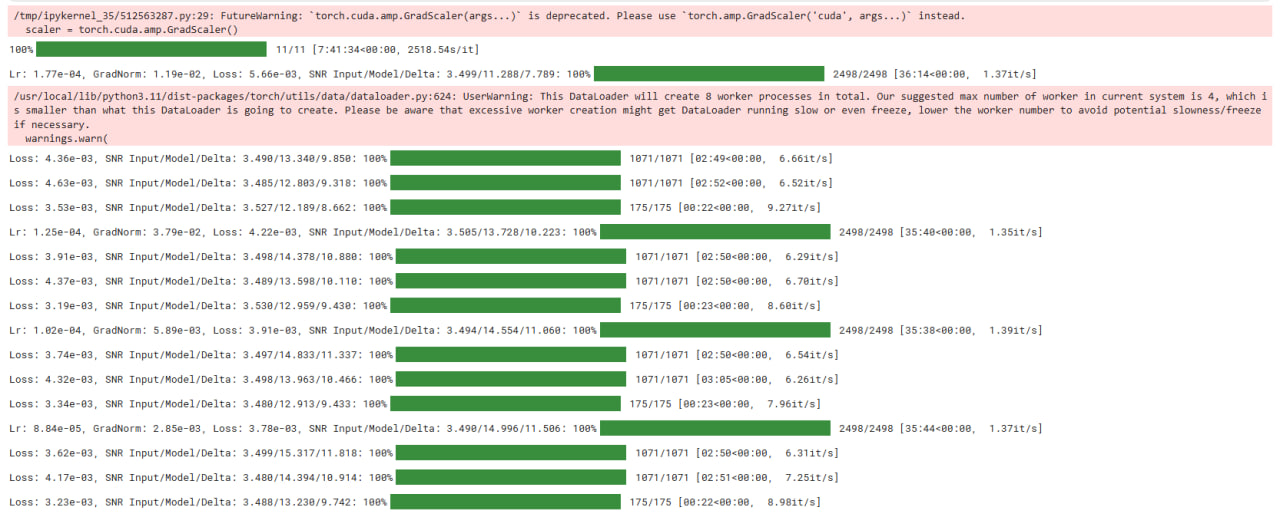
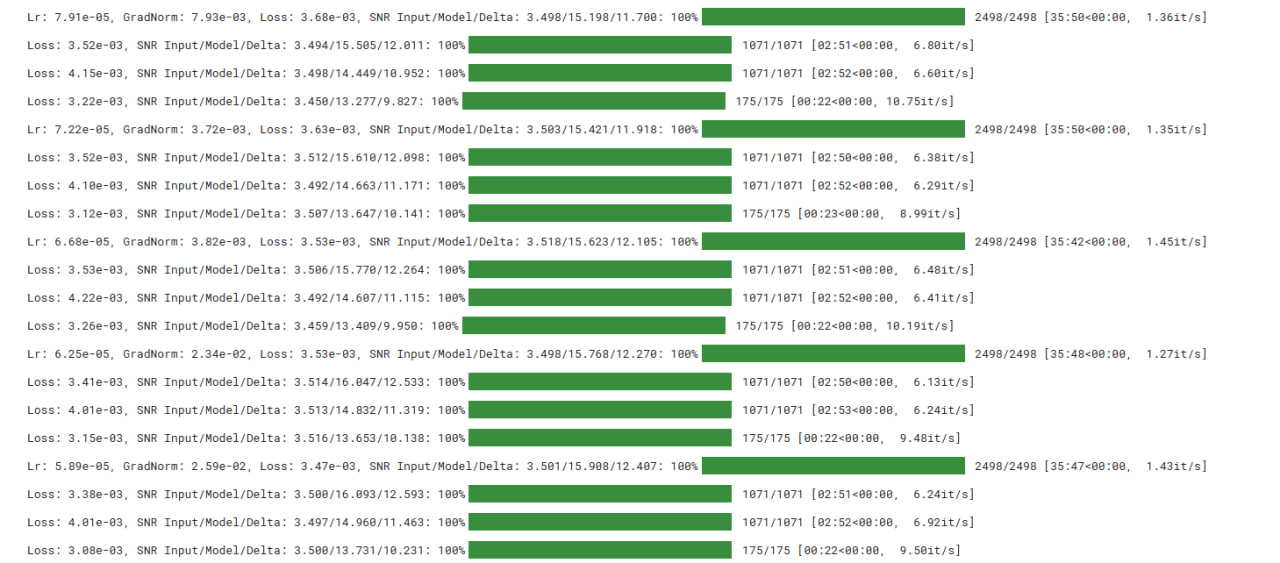
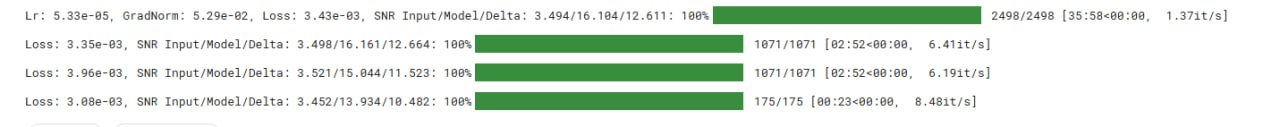
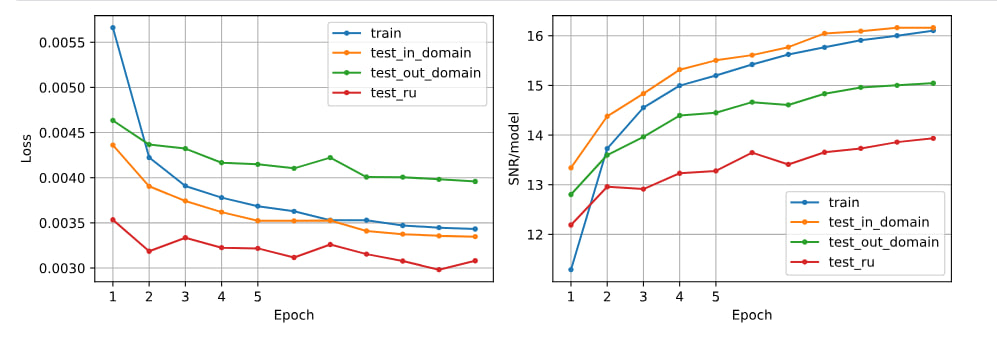

Модель побила значиние SNR в 15 на out_domain шуме на 11 эпохе обучения. К посылке приложил логи и результаты.

In [ ]:
metrics = {
    ds_name: {
        'Loss': [metrics[ds_name]['Loss'] for metrics in results],
        'SNR/model': [metrics[ds_name]['SNR/model'] for metrics in results]
    }
    for ds_name in results[0]
}

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

for ds_name, values in metrics.items():
    axes[0].plot(values['Loss'], label=ds_name, marker='.')
    axes[1].plot(values['SNR/model'], label=ds_name, marker='.')

axes[0].grid(True)
axes[1].grid(True)

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('SNR/model')

axes[0].set_xticks(np.arange(5), np.arange(1, 6))
axes[1].set_xticks(np.arange(5), np.arange(1, 6))
    
fig.tight_layout()
plt.show()

In [ ]:
plot_sample_info(*ru_ds[2], model, device)

In [ ]:
plot_sample_info(*ru_ds[5], model, device)

In [ ]:
plot_sample_info(*ru_ds[7], model, device)

In [ ]:
plot_sample_info(*test_in_ds[2], model, device)

In [ ]:
plot_sample_info(*test_in_ds[5], model, device)

In [ ]:
plot_sample_info(*test_in_ds[7], model, device)

In [ ]:
plot_sample_info(*test_out_ds[2], model, device)

In [ ]:
plot_sample_info(*test_out_ds[5], model, device)

In [ ]:
plot_sample_info(*test_out_ds[7], model, device)

In [ ]:
plot_sample_info(*test_out_ds[12], model, device)

# `Бонус. Метрики качества (до 3 баллов)`

Проверите анализ литературы и предложите альтернативную метрику оценки качества денойзинга. 

Приведите замеры качества с использованием этой метрики. Сравните её с $\text{SNR}_{\text{model}}$. 

Приведите примеры сэмплов где новая метрика лучше отражает качество денойзинга, а где проигрывает $\text{SNR}_{\text{model}}$.

# `Бонус. Длинные последовательности (до 5 баллов)`

Для выполнения этого бонуса нужно исследовать модификации из [**вопроса 2**](#Q2) бонуса про RoPE.

Более конкретно, нужно проанализировать, как модель ведёт себя на последовательностях разной длины, в частности, на последовательностях длины большей, чем использовалась в обучении.

Последовательность действий:
1. Зафиксировать некоторую длину последовательности на которой будет обучаться модель
2. Проанализировать, как меняется SNR в зависимости от длины входной последовательности. Нужно исследовать диапазон вплоть до $3$-$4$ кратной максимальной длины на обучении
3. Построить график SNR от длины входа для моделей с RPE и с RoPE
4. Имплементироввать любую модификацию из [**вопроса 2**](#Q2) в модель RoPE, которая позволит улучшить качество работы на длинных последовательностях. Добавить зависимость SNR от длины входа для модифицированной модели на график
5. Привести несколько примеров работы на длинных последовательностях для всех трёх моделей с использованием `plot_sample_info`